In [110]:
#pip install pandas snowflake-connector-python azure-keyvault-secrets azure-identity

Note: you may need to restart the kernel to use updated packages.


In [112]:
import snowflake.connector
import pandas as pd
from azure.keyvault.secrets import SecretClient
from azure.identity import DefaultAzureCredential

# ------------------------------------------------
# 1. CONNECT TO SNOWFLAKE (your exact connection)
# ------------------------------------------------
vault_url = "https://nectitans6583816546.vault.azure.net/"
client = SecretClient(vault_url=vault_url, credential=DefaultAzureCredential())

conn = snowflake.connector.connect(
    user="MSONG7",
    password="Erynmae06148952",
    account="HTVMPJR-NECDCSF",
    warehouse="NEC_UB_WH",
    database="UB_PREDICTIVE",
    schema="TEAM_TITANS",
)

print("✔ Connection successful!")
cursor = conn.cursor()

###################


✔ Connection successful!


In [115]:
# ------------------------------------------------
# 2. Set path of your forecast csv TO UPLOAD
# ------------------------------------------------
local_csv_path = "/home/azureuser/cloudfiles/code/Users/msong7/purchase_final.csv"
print("Uploading:", local_csv_path)


Uploading: /home/azureuser/cloudfiles/code/Users/msong7/purchase_final.csv


In [116]:
# ------------------------------------------------
# 3. PUT → upload file to Snowflake Stage
# ------------------------------------------------
put_sql = f"""
PUT file://{local_csv_path}
  @FORECAST_STAGE
  AUTO_COMPRESS=TRUE
  OVERWRITE=TRUE;
"""

cursor.execute(put_sql)
print("✔ File uploaded to FORECAST_STAGE")


cursor.execute("LIST @FORECAST_STAGE")
files = cursor.fetchall()
print("\nFiles currently in stage:")
for f in files:
    print(f[0])

✔ File uploaded to FORECAST_STAGE

Files currently in stage:
forecast_stage/forecast_2025_26_27_28_combined.csv.gz
forecast_stage/purchase_final.csv.gz


In [117]:
# ------------------------------------------------
# 4. OVERWRITE + COPY INTO (UPDATED FOR NEW CSV)
# ------------------------------------------------
import os
base_filename = os.path.basename(local_csv_path)
pattern = base_filename.replace(".", r"\.") + r"\.gz$"


print(f"\nLoading staged file by pattern: {pattern} ...")


# STEP A: Create Temporary File Format
create_format_sql = """
CREATE OR REPLACE TEMPORARY FILE FORMAT TEMP_LOAD_FMT
    TYPE = CSV
    SKIP_HEADER = 1
    FIELD_OPTIONALLY_ENCLOSED_BY = '"'
    NULL_IF = ('', 'NULL');
"""
cursor.execute(create_format_sql)
print("✔ Temporary file format created.")


# STEP B: TRUNCATE TABLE → Always overwrite existing data
print("Clearing existing data from FORECAST_PURCHASE...")
cursor.execute("TRUNCATE TABLE FORECAST_PURCHASE;")
print("✔ Table truncated (old data removed).")


# STEP C: COPY INTO with correct 14-column mapping (removed ERROR and APE)
copy_sql = f"""
COPY INTO FORECAST_PURCHASE
    (REGION, COUNTRY, SALESORG, SILHOUETTE, GENDER, SPORT, SEASON,
     YEAR, MONTH, DATE, FORECAST_PURCHASE,
     ACTUAL_PURCHASE, CI_LOWER, CI_UPPER)
FROM (
    SELECT 
        t.$1,
        t.$2,
        t.$3,
        t.$4,
        t.$5,
        t.$6,
        t.$7,
        t.$8::INT,
        t.$9::INT,
        t.$10::DATE,
        t.$11::FLOAT,
        t.$12::FLOAT,
        t.$13::FLOAT,
        t.$14::FLOAT
    FROM @FORECAST_STAGE (FILE_FORMAT => 'TEMP_LOAD_FMT', PATTERN => '{pattern}') t
)
ON_ERROR = 'ABORT_STATEMENT';
"""

print("Loading new CSV data into FORECAST_PURCHASE...")
cursor.execute(copy_sql)
print("✔ Success! Data loaded.")
print("Query ID:", cursor.sfqid)


Loading staged file by pattern: purchase_final\.csv\.gz$ ...
✔ Temporary file format created.
Clearing existing data from FORECAST_PURCHASE...
✔ Table truncated (old data removed).
Loading new CSV data into FORECAST_PURCHASE...
✔ Success! Data loaded.
Query ID: 01c11dc9-0103-4b17-001f-768331916366


In [118]:
# ------------------------------------------------
# 6. FINAL VALIDATION
# ------------------------------------------------
print("\n--- 📊 FINAL COUNT ---")
cursor.execute("SELECT COUNT(*) FROM FORECAST_SALES;")
count = cursor.fetchone()[0]
print(f"Total rows in table: {count}")

if count > 0:
    print("--- 👀 PREVIEW DATA ---")
    cursor.execute("SELECT * FROM FORECAST_SALES LIMIT 5")
    rows = cursor.fetchall()
    for r in rows:
        print(r)


--- 📊 FINAL COUNT ---
Total rows in table: 40425
--- 👀 PREVIEW DATA ---
('EMEA', 'Germany', 'Others', '940', 'Male', 'Others', datetime.date(2025, 1, 1), 2025, datetime.datetime(2025, 12, 10, 14, 24, 20, 420000), 6110.0, 5783.9042132150535, 5839.588548589803, 6710.260565847908, 5839.588548589803, 6710.260565847908, 870.6720172581045)
('EMEA', 'Germany', 'Others', '940', 'Male', 'SP-None', datetime.date(2025, 1, 1), 2025, datetime.datetime(2025, 12, 10, 14, 24, 20, 420000), 150.0, 212.7200827709894, 148.39744075305043, 382.6970400445935, 148.39744075305043, 382.6970400445935, 234.29959929154305)
('EMEA', 'Germany', 'Others', 'Others', 'Male', 'Others', datetime.date(2025, 1, 1), 2025, datetime.datetime(2025, 12, 10, 14, 24, 20, 420000), 13585.0, 15739.253470710795, 12631.865789995749, 13136.938150090326, 12631.865789995749, 13136.938150090326, 505.07236009457847)
('EMEA', 'Germany', 'Others', 'Others', 'Male', 'SP-None', datetime.date(2025, 1, 1), 2025, datetime.datetime(2025, 12, 10, 

In [119]:
# ------------------------------------------------
# 7. CLEANUP (Optional but Recommended)
# ------------------------------------------------
import os

try:
    cleanup_sql = f"""
    REMOVE @FORECAST_STAGE
    PATTERN = '{pattern}';
    """
    cursor.execute(cleanup_sql)
    print(f"✔ Cleaned up staged file(s) matching pattern: {pattern}")
except Exception as e:
    print(f"⚠️ Warning: Could not clean up staged file(s). Error: {e}")

✔ Cleaned up staged file(s) matching pattern: purchase_final\.csv\.gz$


In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import os 
pd.set_option("display.float_format", "{:,.0f}".format)

sql = """
SELECT * FROM ub_predictive.team_titans.PURCHASE_ORDERS_SEASON_NEW
"""

df = pd.read_sql(sql, conn)

print(df.shape)


(78968, 11)


In [121]:
print(df.isna().sum())

REGION              0
COUNTRY             0
SALESORG            0
SILHOUETTE          0
PRODUCT_DIVISION    0
GENDER              0
SPORT               0
SEASON              0
MONTH               0
YEAR                0
PURCHASE_COUNT      0
dtype: int64


In [122]:
# remove missing value
df = df.copy().dropna().reset_index(drop=True)

In [123]:
df.shape

(78968, 11)

In [124]:
df.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'PRODUCT_DIVISION',
       'GENDER', 'SPORT', 'SEASON', 'MONTH', 'YEAR', 'PURCHASE_COUNT'],
      dtype='object')

In [125]:
df["PURCHASE_COUNT"].sum()

1707989902.146

In [126]:
print(df["REGION"].unique())
print(df["COUNTRY"].unique())
print(df["SALESORG"].unique())
print(df["SILHOUETTE"].unique())
print(df["GENDER"].unique())
print(df["SPORT"].unique())
print(df["SEASON"].unique())

['EMEA' 'Emerging Markets' 'North America' 'Japan' 'Unknown']
['United Kingdom' 'Mexico' 'USA' 'Hong Kong' 'South Korea' 'Canada'
 'Japan' 'Australia' 'Germany' 'New Zealand' 'China' 'Unknown']
['EMEA' 'Mexico' 'United States' 'Southeast Asia' 'South Korea'
 'Latin America' 'Canada' 'Japan' 'Australia' 'German' 'New Zealand'
 'NEC China Shanghai' '5th & Ocean' 'Unknown' 'China' 'US Retail'
 '47 Japan' '47 New Zealand' '47 Australia' 'EMEA Web']
['S-920' 'S-3930' 'Others' 'S-940' 'S-950' 'S-5950' 'Apparel']
['Others' 'Boys' 'Male' 'Girls' 'Ladies']
['Others' 'Football' 'Baseball' 'Basketball' 'SP-None' 'College']
['Program' 'Stock' 'Custom' 'UNASSIGNED']


In [127]:

df["SILHOUETTE"] = df["SILHOUETTE"].replace({
    "S-5950": "5950",
    "S-920": "920",
    "S-940": "940",
    "S-950": "950",
    "S-3930": "3930",
})

In [128]:
df["SALESORG"] = df["SALESORG"].replace({
    "US Retail": "United States",
    "NEC China Shanghai": "China",
    "47 Japan": "Japan",
    "47 New Zealand": "New Zealand",
    "47 Australia": "Australia",
    "EMEA Web": "EMEA",
})

In [129]:
print("SALESORG",df["SALESORG"].unique())
print("SILHOUETTE",df["SILHOUETTE"].unique())



SALESORG ['EMEA' 'Mexico' 'United States' 'Southeast Asia' 'South Korea'
 'Latin America' 'Canada' 'Japan' 'Australia' 'German' 'New Zealand'
 'China' '5th & Ocean' 'Unknown']
SILHOUETTE ['920' '3930' 'Others' '940' '950' '5950' 'Apparel']


In [130]:
# View the number of transaction lines per month for 2025
cnt_2025 = (
    df[df["YEAR"] == 2025]
    .groupby("MONTH")
    .size()
    .reset_index(name="N_ROWS")
    .sort_values("MONTH")
)
print(cnt_2025)

Empty DataFrame
Columns: [MONTH, N_ROWS]
Index: []


## Handling missing values

In [131]:
df_new=df.copy()
missing_count = df_new.isna().sum()
missing_percent = (df_new.isna().sum() / len(df_new)) * 100
missing_table = pd.DataFrame({
    "Missing Count": missing_count,
    "Missing %": missing_percent.round(2)
})

print("=== Missing Value Summary ===")
print(missing_table.sort_values("Missing %", ascending=False))

=== Missing Value Summary ===
                  Missing Count  Missing %
REGION                        0          0
COUNTRY                       0          0
SALESORG                      0          0
SILHOUETTE                    0          0
PRODUCT_DIVISION              0          0
GENDER                        0          0
SPORT                         0          0
SEASON                        0          0
MONTH                         0          0
YEAR                          0          0
PURCHASE_COUNT                0          0


In [132]:
# 1. Copy all dimension columns that need to be retained (excluding YEAR/MONTH/numeric columns).
feature_cols = [
    'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 
    'GENDER', 'SPORT', 'SEASON'
]
group_cols =[
    'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 
    'GENDER', 'SPORT', 'SEASON'
]
features = df_new[feature_cols].drop_duplicates()

# Establish a 36-month skeleton for 2026–2028
years = [2026, 2027, 2028]
months = list(range(1, 13))

future_26_28 = features.merge(
    pd.DataFrame(
        [(y, m) for y in years for m in months],
        columns=["YEAR", "MONTH"]
    ),
    how="cross"
)

future_26_28["TOTAL_PURCHASE_COUNT"] = np.nan

In [133]:
df=df_new

#missing value
missing_count = df.isna().sum()
missing_percent = (df.isna().sum() / len(df)) * 100
missing_table = pd.DataFrame({
    "Missing Count": missing_count,
    "Missing %": missing_percent.round(2)
})

print("=== Missing Value Summary ===")
print(missing_table.sort_values("Missing %", ascending=False))

=== Missing Value Summary ===
                  Missing Count  Missing %
REGION                        0          0
COUNTRY                       0          0
SALESORG                      0          0
SILHOUETTE                    0          0
PRODUCT_DIVISION              0          0
GENDER                        0          0
SPORT                         0          0
SEASON                        0          0
MONTH                         0          0
YEAR                          0          0
PURCHASE_COUNT                0          0


In [134]:
dfb = df.copy()
# time features transfer to numeric
dfb["YEAR"] = pd.to_numeric(dfb["YEAR"], errors="coerce").astype("Int16")
dfb["MONTH"] = pd.to_numeric(dfb["MONTH"], errors="coerce").astype("Int8")
dfb["PURCHASE_COUNT"] = pd.to_numeric(dfb["PURCHASE_COUNT"], errors="coerce")

dfb = dfb.dropna(subset=["YEAR","MONTH","PURCHASE_COUNT"])

dfb["DATE"] = pd.to_datetime(
    dfb["YEAR"].astype(str) + "-" + dfb["MONTH"].astype(str)
)
dfb["DATE"] = pd.to_datetime(dfb["DATE"]).dt.to_period("M")

In [135]:
from sklearn.preprocessing import LabelEncoder

features = [
    'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 
    'GENDER', 'SPORT', 'SEASON'
]

label_encoders = {}


dfb = dfb.copy()

# Label Encoding 
for col in features:
    le = LabelEncoder()
    dfb[col] = le.fit_transform(dfb[col].astype(str))
    label_encoders[col] = le  # save

for col in features:
    le = LabelEncoder()
    future_26_28[col] = le.fit_transform(future_26_28[col].astype(str))
    #label_encoders[col] = le

In [136]:
import pickle

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

In [137]:
def show_rows(name, df):
    print(f"{name:<20} -> rows = {len(df):,}")

## Handling outliners

In [138]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL

# -------- 0. Basic Preparation --------
dfb = dfb.copy()

#1) Ensure DATE is a datetime (to avoid PeriodDtype errors)）
if pd.api.types.is_period_dtype(dfb["DATE"]):
    dfb["DATE"] = dfb["DATE"].dt.to_timestamp()

dfb["DATE"] = pd.to_datetime(dfb["DATE"])

# 2) Convert PURCHASE_COUNT to numeric value (remove commas)
dfb["PURCHASE_COUNT"] = (
    dfb["PURCHASE_COUNT"]
      .astype(str)
      .astype(float)
)

# 3) Define the grouping column
group_cols = ['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 
    'GENDER', 'SPORT', 'SEASON']

def remove_outliers_stl(series, freq=12, z_high=5.5, z_low=3.0):
    '''
    - First perform STL decomposition: trend + seasonal + residual
    - High values: residual > z_high * std (e.g., 5.5σ, only considered extremely high)
    - Low values: resid < -z_low * std (e.g., 3σ, moderately trimming extreme lows)
    - Mark these positions as NaN, then interpolate over time
    '''
    #For groups with insufficient samples, skip STL processing and return the original sequence directly.
    if series.dropna().shape[0] < freq * 2:
        outliers = pd.Series(False, index=series.index)
        return series.copy(), outliers

    stl = STL(series, period=freq, robust=True)
    result = stl.fit()

    resid = result.resid
    resid_std = resid.std(ddof=1)

    # High outlier
    high_outliers = resid >  z_high * resid_std
    # low outlier
    low_outliers  = resid < -z_low  * resid_std

    # Combine the two
    outliers = high_outliers | low_outliers

    cleaned = series.copy()
    cleaned[outliers] = np.nan
    cleaned = cleaned.interpolate(method='time') 

    return cleaned, outliers

cleaned_list = []

for keys, group in dfb.groupby(group_cols):
    g = group.sort_values("DATE").set_index("DATE")

    
    cleaned, outliers = remove_outliers_stl(
        g["PURCHASE_COUNT"],
        freq=12,
        z_high=7,   
        z_low=2.0     
    )

    g["PC_CLEAN"]     = cleaned
    g["OUTLIER_FLAG"] = outliers

    cleaned_list.append(g.reset_index())


df_clean = pd.concat(cleaned_list, ignore_index=True)


In [139]:
print(show_rows('after removing outliners',df_clean))

after removing outliners -> rows = 78,968
None


In [140]:
df_clean.columns

Index(['DATE', 'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE',
       'PRODUCT_DIVISION', 'GENDER', 'SPORT', 'SEASON', 'MONTH', 'YEAR',
       'PURCHASE_COUNT', 'PC_CLEAN', 'OUTLIER_FLAG'],
      dtype='object')

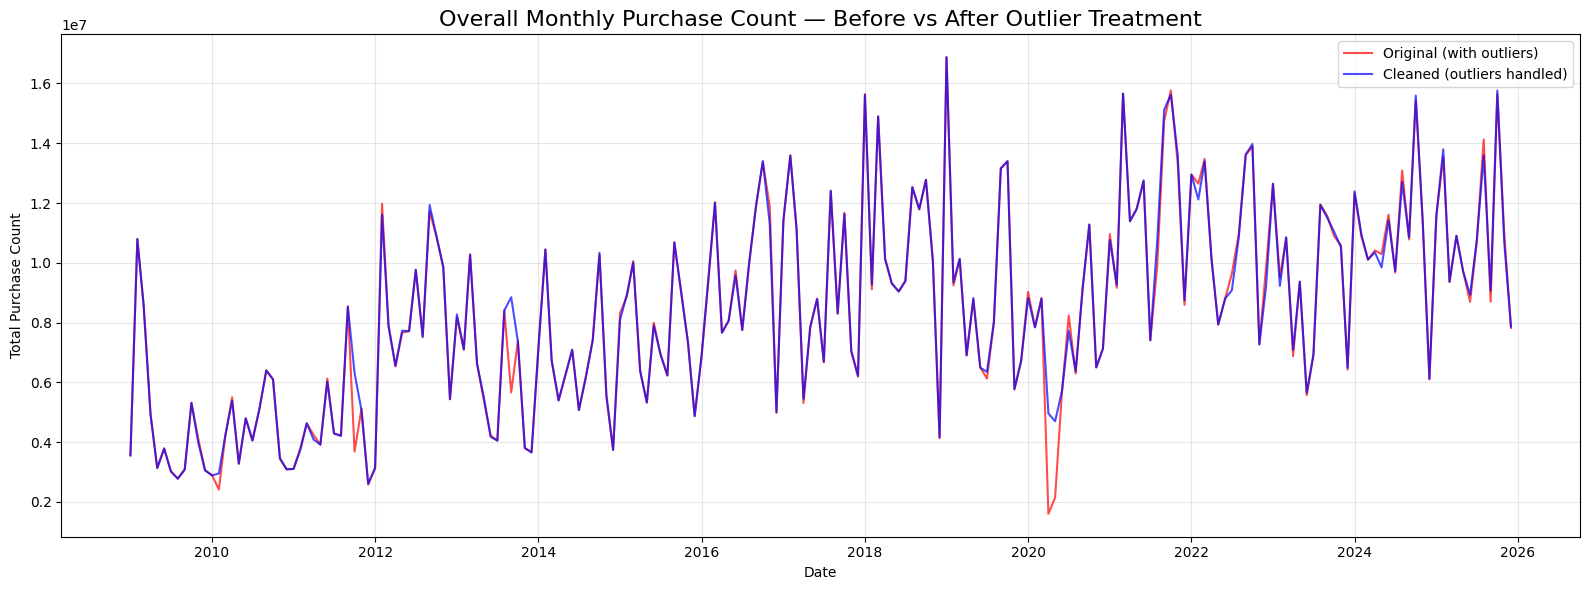

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# ——————————————
# 1. Prepare the original monthly totals
# ——————————————
orig_monthly = (
    dfb.groupby(["YEAR", "MONTH"], as_index=False)["PURCHASE_COUNT"]
       .sum()
       .sort_values(["YEAR", "MONTH"])
)

orig_monthly["DATE"] = pd.to_datetime(
    orig_monthly["YEAR"].astype(str) + "-" +
    orig_monthly["MONTH"].astype(str) + "-01"
)

orig_monthly = orig_monthly.set_index("DATE")


# ——————————————
# 2. Prepare the monthly totals after cleaning
# ——————————————
clean_monthly = (
    df_clean.groupby(["YEAR", "MONTH"], as_index=False)["PC_CLEAN"]
            .sum()
            .sort_values(["YEAR", "MONTH"])
)

clean_monthly["DATE"] = pd.to_datetime(
    clean_monthly["YEAR"].astype(str) + "-" +
    clean_monthly["MONTH"].astype(str) + "-01"
)

clean_monthly = clean_monthly.set_index("DATE")


# ——————————————
# 3. Create a comparison chart
# ——————————————
plt.figure(figsize=(16, 6))
plt.plot(orig_monthly.index, orig_monthly["PURCHASE_COUNT"],
         label="Original (with outliers)", color="red", alpha=0.7)

plt.plot(clean_monthly.index, clean_monthly["PC_CLEAN"],
         label="Cleaned (outliers handled)", color="blue", alpha=0.7)

plt.title("Overall Monthly Purchase Count — Before vs After Outlier Treatment",
          fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchase Count")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [142]:
dfclean_25agg = df_clean[df_clean["YEAR"] == 2025].copy()

# Aggregate by year + month
clean_monthly_25df = (
    dfclean_25agg
    .groupby(["YEAR", "MONTH"], as_index=False)["PC_CLEAN"]
    .sum()
)

print(clean_monthly_25df)

    YEAR  MONTH   PC_CLEAN
0   2025      1 11,567,984
1   2025      2 13,797,871
2   2025      3  9,365,830
3   2025      4 10,908,340
4   2025      5  9,714,637
5   2025      6  8,930,642
6   2025      7 10,755,827
7   2025      8 13,596,612
8   2025      9  9,071,486
9   2025     10 15,764,669
10  2025     11 10,677,155
11  2025     12  7,871,144


## Feature Engineered

In [143]:
# 1. Historical data: Retain only 2009–2025; using `df_clean` is sufficient.

hist_df = df_clean.copy()   # The df_clean dataset only contains data from 2009 to 2025.

print("Historical rows (2009–2025):", len(hist_df))

# 2. Perform a groupby operation using only historical data to obtain df_final (excluding 2026).
df_final = (
    hist_df
    .groupby(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 
     'GENDER', 'SPORT', 'SEASON', 'YEAR', 'MONTH'], as_index=False)[['PC_CLEAN']]
    .sum()
)

df_final.rename(columns={
    'PC_CLEAN': 'TOTAL_PURCHASE_COUNT'
}, inplace=True)

df_final["DATE"] = pd.to_datetime(
    df_final["YEAR"].astype(str) + "-" + df_final["MONTH"].astype(str) + "-01"
)
df_final = df_final.sort_values(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 
    'GENDER', 'SPORT', 'SEASON', "DATE"])

# 3. Calculate Lag on df_final (only up to 2025)
lags = [1, 3, 6, 12, 24]
for lag in lags:
    df_final[f"LAG_{lag}"] = (
        df_final
        .groupby(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 
    'GENDER', 'SPORT', 'SEASON'])["TOTAL_PURCHASE_COUNT"]
        .shift(lag)
    )

# 4. Rolling is only considered in historical terms.
group_cols = ['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 
    'GENDER', 'SPORT', 'SEASON']
roll_windows = [ 3, 6]

for w in roll_windows:
    col = f"ROLL_MEAN_{w}"
    df_final[col] = (
        df_final
        .groupby(group_cols)["TOTAL_PURCHASE_COUNT"]
        .transform(lambda s: s.rolling(window=w, min_periods=1).mean().shift(1))
    )

print("Lag Missing：")
print(df_final[[f"LAG_{l}" for l in lags]].isna().sum())
print("Rolling Missing：")
print(df_final[[f"ROLL_MEAN_{w}" for w in roll_windows]].isna().sum())

lag_cols  = [f"LAG_{l}" for l in lags]
roll_cols = [f"ROLL_MEAN_{w}" for w in roll_windows]

df_final["Y_LOG"] = np.log1p(df_final["TOTAL_PURCHASE_COUNT"])

df_final['MONTH_SIN'] = np.sin(2*np.pi*df_final['MONTH']/12)
df_final['MONTH_COS'] = np.cos(2*np.pi*df_final['MONTH']/12)
df_final['YEAR_INDEX'] = df_final['YEAR'] - df_final['YEAR'].min()

df_final["ANCHOR_MEAN_3"] = (
    df_final.groupby(group_cols)["TOTAL_PURCHASE_COUNT"]
            .transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1))
)

df_final["ANCHOR_MEAN_6"] = (
    df_final.groupby(group_cols)["TOTAL_PURCHASE_COUNT"]
            .transform(lambda x: x.rolling(6, min_periods=1).mean().shift(1))
)

df_final["ANCHOR_DYNAMIC"] = (
    0.7 * df_final["ANCHOR_MEAN_3"] + 
    0.3 * df_final["ANCHOR_MEAN_6"]
)
######TREND
df_final["TREND_3"] = (
    df_final.groupby(group_cols)["TOTAL_PURCHASE_COUNT"]
           .transform(lambda x: x.diff(3))
)
df_final["TREND_6"] = (
    df_final.groupby(group_cols)["TOTAL_PURCHASE_COUNT"]
           .transform(lambda x: x.diff(6))
)
df_final["TREND_RATE_3"] = (
    df_final.groupby(group_cols)["TOTAL_PURCHASE_COUNT"]
           .transform(lambda x: x.pct_change(3))
)
######YOY CHANGE
eps = 1e-6
df_final["YOY_CHANGE"] = (df_final["TOTAL_PURCHASE_COUNT"] - df_final["LAG_12"]) / (df_final["LAG_12"].abs() + eps)

# Handling exceptions/missing values
df_final["YOY_CHANGE"] = df_final["YOY_CHANGE"].replace([np.inf, -np.inf], np.nan).fillna(0.0)

time_cols = ["MONTH_SIN","MONTH_COS","YEAR_INDEX","ANCHOR_DYNAMIC","TREND_3","TREND_6","TREND_RATE_3","YOY_CHANGE"]

print("Train rows:", len(df_final))

# 5. Future forecast data (2026) shall remain independent and not participate in lag/rolling calculations.
future_df = future_26_28.copy()
print("Future rows (2026 skeleton):", len(future_df))

Historical rows (2009–2025): 78968
Lag Missing：
LAG_1      2475
LAG_3      6375
LAG_6     11120
LAG_12    18699
LAG_24    30375
dtype: int64
Rolling Missing：
ROLL_MEAN_3    2475
ROLL_MEAN_6    2475
dtype: int64
Train rows: 77296
Future rows (2026 skeleton): 89100


## Fit the Model

In [144]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# ===== Feature Column & Target Column =====
feature_cols = group_cols + ["YEAR", "MONTH"] + lag_cols + roll_cols+ time_cols
target_col = "Y_LOG"

X_train = df_final[feature_cols].astype(float)
y_train = df_final[target_col].astype(float)

print("X_train shape:", X_train.shape)

# ===== CatBoost =====
model_cat = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    n_estimators=400,
    loss_function="RMSE",
    random_state=42,
    verbose=False
)
model_cat.fit(X_train, y_train)

from catboost import CatBoostRegressor

# ===== MultiQuantile : 0.05, 0.5, 0.95 =====
model_mq = CatBoostRegressor(
    loss_function="MultiQuantile:alpha=0.05,0.5,0.95",
    depth=8,
    learning_rate=0.03,
    n_estimators=800,     
    random_state=42,
    verbose=False
)

model_mq.fit(X_train, y_train)   # Y_LOG

# std
train_pred_cat = model_cat.predict(X_train)
std_res_cat = np.std(y_train - train_pred_cat)

print("CatBoost train RMSE:",
      np.sqrt(np.mean((y_train - train_pred_cat) ** 2)))


X_train shape: (77296, 24)
CatBoost train RMSE: 0.45743749810051293


In [145]:
import pandas as pd

def autoregressive_forecast_2026_2028(
    model,
    df_hist,
    lag_list,
    roll_windows,
    group_cols,
    feature_cols
):
    preds = []

    # All group combinations
    groups = df_hist[group_cols].drop_duplicates().values

    for g in groups:
        # order by time
        mask = (df_hist[group_cols[0]] == g[0])
        for i, col in enumerate(group_cols[1:], start=1):
            mask &= (df_hist[col] == g[i])

        df_g = df_hist[mask].sort_values(["YEAR", "MONTH"]).copy()
        anchor_last = df_g["ANCHOR_DYNAMIC"].iloc[-1]
        df_g["TREND_3"].iloc[-1]
        df_g["TREND_6"].iloc[-1]
        df_g["TREND_RATE_3"].iloc[-1]

        # History y sequence
        y_hist = df_g["TOTAL_PURCHASE_COUNT"].tolist()

        # 2026–2028, 36 monhs
        for year in [2026, 2027, 2028]:
            for month in range(1, 13):

                feat = {}

                # group constant features
                for idx, col in enumerate(group_cols):
                    feat[col] = g[idx]

                feat["YEAR"] = year
                feat["MONTH"] = month

                # ----------------------------
                # New: Time Feature
                # ----------------------------
                feat["MONTH_SIN"] = np.sin(2*np.pi*month/12)
                feat["MONTH_COS"] = np.cos(2*np.pi*month/12)
                feat["YEAR_INDEX"] = year - df_hist["YEAR"].min()
                # New: Trend Characteristics (derived from historical data, unaffected by forecasts)
                feat["ANCHOR_DYNAMIC"] = anchor_last
                feat["TREND_3"] = df_g["TREND_3"].iloc[-1]
                feat["TREND_6"] = df_g["TREND_6"].iloc[-1]
                trend_rate = df_g["TREND_RATE_3"].iloc[-1]
                feat["TREND_RATE_3"] = 0 if pd.isna(trend_rate) or np.isinf(trend_rate) else trend_rate
                # ----------------------------

                # lag 
                for L in lag_list:
                    if len(y_hist) >= L:
                        feat[f"LAG_{L}"] = y_hist[-L]
                    else:
                        feat[f"LAG_{L}"] = np.nan

                # rolling 
                for w in roll_windows:
                    if len(y_hist) >= w:
                        feat[f"ROLL_MEAN_{w}"] = np.mean(y_hist[-w:])
                    else:
                        feat[f"ROLL_MEAN_{w}"] = np.nan

                # yoy_change (based on LAG_1 vs LAG_12, original scale)
                lag1  = feat.get("LAG_1", np.nan)
                lag12 = feat.get("LAG_12", np.nan)

                if (not pd.isna(lag1)) and (not pd.isna(lag12)) and (lag12 != 0):
                    yoy = (lag1 - lag12) / (abs(lag12) + 1e-6)
                else:
                    yoy = 0.0
                feat["YOY_CHANGE"]=yoy
                
                row = pd.DataFrame([feat])
                X_row = row[feature_cols].astype(float)

                y_hat = float(np.expm1(model.predict(X_row)[0]))

                preds.append({
                    **{col: g[i] for i, col in enumerate(group_cols)},
                    "YEAR": year,
                    "MONTH": month,
                    "PRED": y_hat
                })

                # Add the forecast values back to y_hist for use in subsequent months.
                y_hist.append(y_hat)

    df_pred = pd.DataFrame(preds)
    df_pred["DATE"] = pd.to_datetime(
        df_pred["YEAR"].astype(str) + "-" + df_pred["MONTH"].astype(str) + "-01"
    )

    return df_pred

In [146]:
import numpy as np
import pandas as pd

def autoregressive_forecast_mq_2026_2028(
    model_rmse,          # RMSE 
    model_mq,            # MultiQuantile 
    df_hist,
    lag_list,
    roll_windows,
    group_cols,
    feature_cols
):

    preds = []

    groups = df_hist[group_cols].drop_duplicates().values

    for g in groups:
        # 1) Retrieve the history of this group, sorted by time.
        mask = (df_hist[group_cols[0]] == g[0])
        for i, col in enumerate(group_cols[1:], start=1):
            mask &= (df_hist[col] == g[i])

        df_g = df_hist[mask].sort_values(["YEAR", "MONTH"]).copy()
        if df_g.empty:
            continue

        # History's Final Line: Anchor & Trend (Keep Frozen)
        anchor_last     = df_g["ANCHOR_DYNAMIC"].iloc[-1]
        trend_3_last    = df_g["TREND_3"].iloc[-1]
        trend_6_last    = df_g["TREND_6"].iloc[-1]
        trend_rate_last = df_g["TREND_RATE_3"].iloc[-1]
        if pd.isna(trend_rate_last) or np.isinf(trend_rate_last):
            trend_rate_last = 0.0

        # Reset to historical sequence (original scale): Initialize with TOTAL_PURCHASE_COUNT
        y_hist = df_g["TOTAL_PURCHASE_COUNT"].tolist()

        # 2) Future 36-Month Cycle
        for year in [2026, 2027, 2028]:
            for month in range(1, 13):

                feat = {}

                for idx, col in enumerate(group_cols):
                    feat[col] = g[idx]

                feat["YEAR"] = year
                feat["MONTH"] = month

                # Time Characteristics
                feat["MONTH_SIN"]  = np.sin(2*np.pi*month/12)
                feat["MONTH_COS"]  = np.cos(2*np.pi*month/12)
                feat["YEAR_INDEX"] = year - df_hist["YEAR"].min()

                # Anchors & Trends
                feat["ANCHOR_DYNAMIC"] = anchor_last
                feat["TREND_3"]        = trend_3_last
                feat["TREND_6"]        = trend_6_last
                feat["TREND_RATE_3"]   = trend_rate_last

                # lag
                for L in lag_list:
                    if len(y_hist) >= L:
                        feat[f"LAG_{L}"] = y_hist[-L]
                    else:
                        feat[f"LAG_{L}"] = np.nan

                # rolling
                for w in roll_windows:
                    if len(y_hist) >= w:
                        feat[f"ROLL_MEAN_{w}"] = np.mean(y_hist[-w:])
                    else:
                        feat[f"ROLL_MEAN_{w}"] = np.nan
                # yoy_change
                lag1  = feat.get("LAG_1", np.nan)
                lag12 = feat.get("LAG_12", np.nan)

                if (not pd.isna(lag1)) and (not pd.isna(lag12)) and (lag12 != 0):
                    yoy = (lag1 - lag12) / (abs(lag12) + 1e-6)
                else:
                    yoy = 0.0

                feat["YOY_CHANGE"]=yoy
                
                row = pd.DataFrame([feat])
                X_row = row[feature_cols].astype(float)

                # ====== predict using the RMSE model (log → original scale)======
                y_log_rmse = model_rmse.predict(X_row)[0]
                y_rmse = float(np.expm1(y_log_rmse))

                # ====== use the MultiQuantile model to predict (log → original scale)======
                q_log = model_mq.predict(X_row)[0]   # [q05, q50, q95]
                y_p05 = float(np.expm1(q_log[0]))
                y_p50 = float(np.expm1(q_log[1]))
                y_p95 = float(np.expm1(q_log[2]))

                low  = min(y_p05, y_p50, y_p95)
                mid  = np.median([y_p05, y_p50, y_p95])
                high = max(y_p05, y_p50, y_p95)

                preds.append({
                    **{col: g[i] for i, col in enumerate(group_cols)},
                    "YEAR": year,
                    "MONTH": month,
                    "PRED_RMSE": y_rmse,
                    "PRED_p05":  low,
                    "PRED_p50":  mid,
                    "PRED_p95":  high
                })

                # Self-regression: Only include RMSE predictions in y_hist; quantiles are excluded from updates.
                y_hist.append(y_rmse)

    df_pred = pd.DataFrame(preds)
    df_pred["DATE"] = pd.to_datetime(
        df_pred["YEAR"].astype(str) + "-" + df_pred["MONTH"].astype(str) + "-01"
    )
    return df_pred

## Forecasting for 2026-2028

In [147]:
# 2) RMSE
cat_pred_26_28 = autoregressive_forecast_2026_2028(
    model_cat,
    df_hist=df_final,          # 2009-2025
    lag_list=lags,
    roll_windows=roll_windows,
    group_cols=group_cols,
    feature_cols=feature_cols
)



In [148]:

# 2) MultiQuantile 
mq_pred_26_28 = autoregressive_forecast_mq_2026_2028(
    model_rmse=model_cat,
    model_mq=model_mq,
    df_hist=df_final,
    lag_list=lags,
    roll_windows=roll_windows,
    group_cols=group_cols,
    feature_cols=feature_cols
)

In [149]:
sum_cat=cat_pred_26_28["PRED"].sum()
print(sum_cat)

865528510.5340056


In [150]:
cat_pred_26_28.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'PRED', 'DATE'],
      dtype='object')

In [151]:
cat_ci=cat_pred_26_28[['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'PRED', 'DATE']].copy()

In [152]:
import numpy as np
from scipy.stats import norm

sigma = 1000
# 95% CI multiplier
z = norm.ppf(0.975)   # = 1.96

# Add CI columns
cat_ci["LOWER_CI"] = cat_ci["PRED"] - z * sigma
cat_ci["UPPER_CI"] = cat_ci["PRED"] + z * sigma

In [153]:
cat_ci["LOWER_CI"] = cat_ci["LOWER_CI"].clip(lower=0)


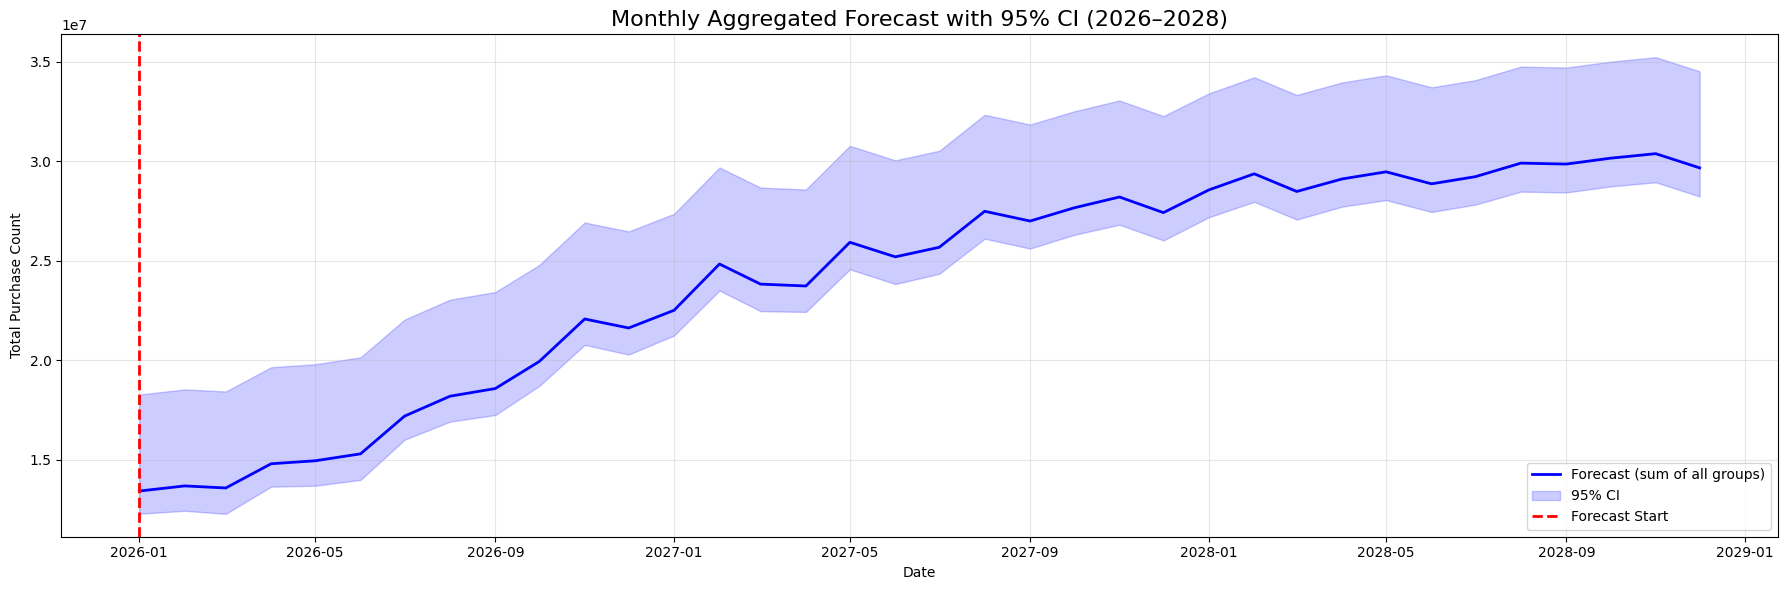

In [154]:
###########
#cat_ci plot with upper and lower bound
###########

monthly_cat_ci = (
    cat_ci.groupby("DATE")[["PRED", "LOWER_CI", "UPPER_CI"]]
          .sum()
          .reset_index()
          .sort_values("DATE")
)

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

plt.plot(
    monthly_cat_ci["DATE"],
    monthly_cat_ci["PRED"],
    color="blue",
    linewidth=2,
    label="Forecast (sum of all groups)"
)

plt.fill_between(
    monthly_cat_ci["DATE"],
    monthly_cat_ci["LOWER_CI"],
    monthly_cat_ci["UPPER_CI"],
    color="blue",
    alpha=0.2,
    label="95% CI"
)

plt.axvline(pd.to_datetime("2026-01-01"), color="red", linestyle="--", linewidth=2, label="Forecast Start")

plt.title("Monthly Aggregated Forecast with 95% CI (2026–2028)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchase Count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [155]:
top15_cat=cat_pred_26_28.sort_values("PRED",ascending=False).head(15)
print(top15_cat)

       REGION  COUNTRY  SALESORG  SILHOUETTE  GENDER  SPORT  SEASON  YEAR  \
89076       4       11        13           6       4      4       3  2027   
89077       4       11        13           6       4      4       3  2027   
89072       4       11        13           6       4      4       3  2026   
89085       4       11        13           6       4      4       3  2027   
89088       4       11        13           6       4      4       3  2028   
89089       4       11        13           6       4      4       3  2028   
89065       4       11        13           6       4      4       3  2026   
89097       4       11        13           6       4      4       3  2028   
89096       4       11        13           6       4      4       3  2028   
89084       4       11        13           6       4      4       3  2027   
89064       4       11        13           6       4      4       3  2026   
89066       4       11        13           6       4      4       3  2026   

In [156]:
mq_pred_26_28.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'PRED_RMSE', 'PRED_p05', 'PRED_p50',
       'PRED_p95', 'DATE'],
      dtype='object')

In [157]:
top15_p50=mq_pred_26_28.sort_values("PRED_p50",ascending=False).head(15)
print(top15_p50)

       REGION  COUNTRY  SALESORG  SILHOUETTE  GENDER  SPORT  SEASON  YEAR  \
89069       4       11        13           6       4      4       3  2026   
89068       4       11        13           6       4      4       3  2026   
89072       4       11        13           6       4      4       3  2026   
89075       4       11        13           6       4      4       3  2026   
89066       4       11        13           6       4      4       3  2026   
89067       4       11        13           6       4      4       3  2026   
89077       4       11        13           6       4      4       3  2027   
89093       4       11        13           6       4      4       3  2028   
89070       4       11        13           6       4      4       3  2026   
89078       4       11        13           6       4      4       3  2027   
89074       4       11        13           6       4      4       3  2026   
89080       4       11        13           6       4      4       3  2027   

In [158]:
df_hist_all = df_final.copy()
df_hist_all["DATE"] = pd.to_datetime(df_hist_all["DATE"])

monthly_hist = (
    df_hist_all.groupby("DATE")["TOTAL_PURCHASE_COUNT"]
               .sum()
               .reset_index()
)

In [159]:
# --- CatBoost ---
monthly_cat = (
    cat_pred_26_28.groupby("DATE")["PRED"]
                  .sum()
                  .reset_index()
)
monthly_cat.rename(columns={"PRED": "PRED_CAT"}, inplace=True)

# 95% CI
monthly_cat["LOWER_CAT"] = monthly_cat["PRED_CAT"] - 1.96 * std_res_cat
monthly_cat["UPPER_CAT"] = monthly_cat["PRED_CAT"] + 1.96 * std_res_cat

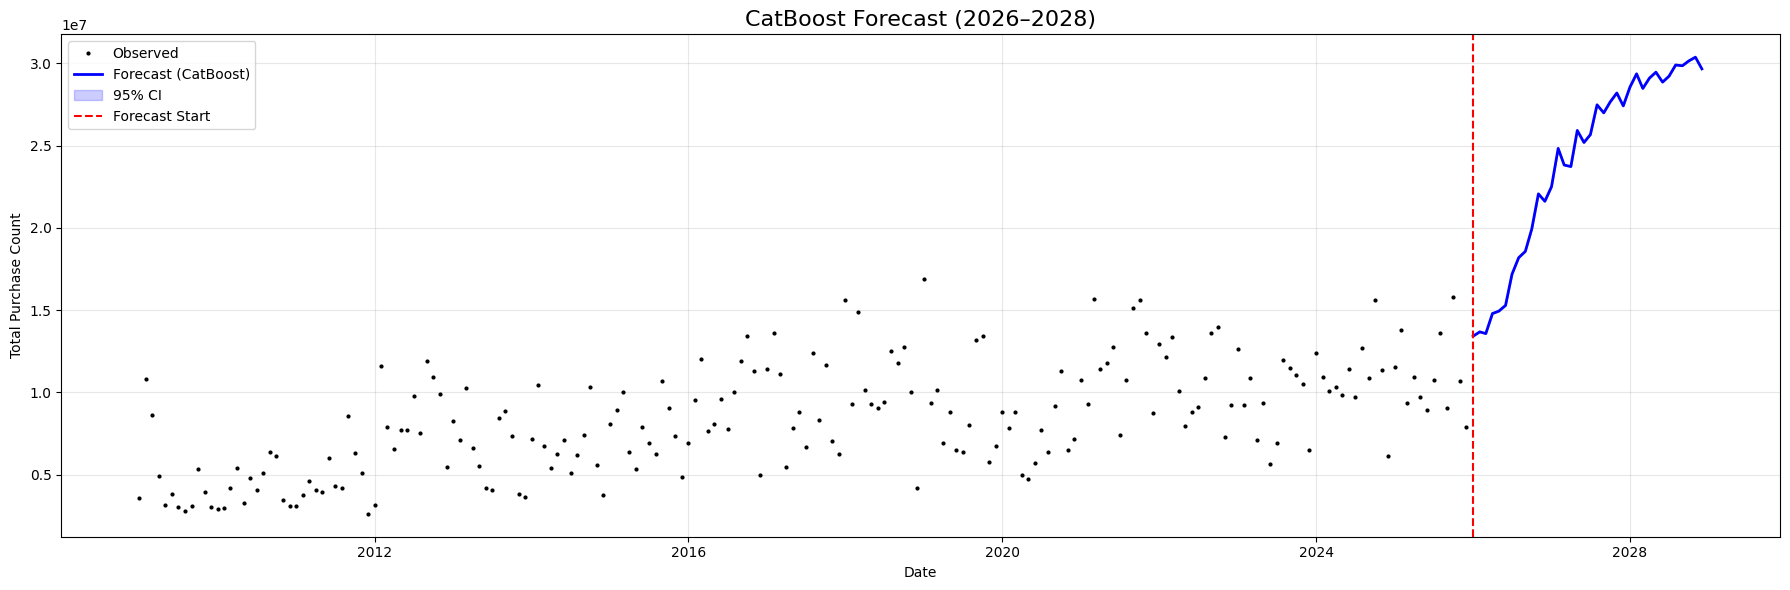

In [160]:
plt.figure(figsize=(18, 6))

# observed
plt.plot(
    monthly_hist["DATE"],
    monthly_hist["TOTAL_PURCHASE_COUNT"],
    "k.", markersize=4, label="Observed"
)

# forecast
plt.plot(
    monthly_cat["DATE"],
    monthly_cat["PRED_CAT"],
    color="blue", linewidth=2, label="Forecast (CatBoost)"
)

plt.fill_between(
    monthly_cat["DATE"],
    monthly_cat["LOWER_CAT"],
    monthly_cat["UPPER_CAT"],
    color="blue", alpha=0.2, label="95% CI"
)

# vertical line for start of forecast
plt.axvline(pd.to_datetime("2026-01-01"), color="red", linestyle="--", label="Forecast Start")

plt.title("CatBoost Forecast (2026–2028)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchase Count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

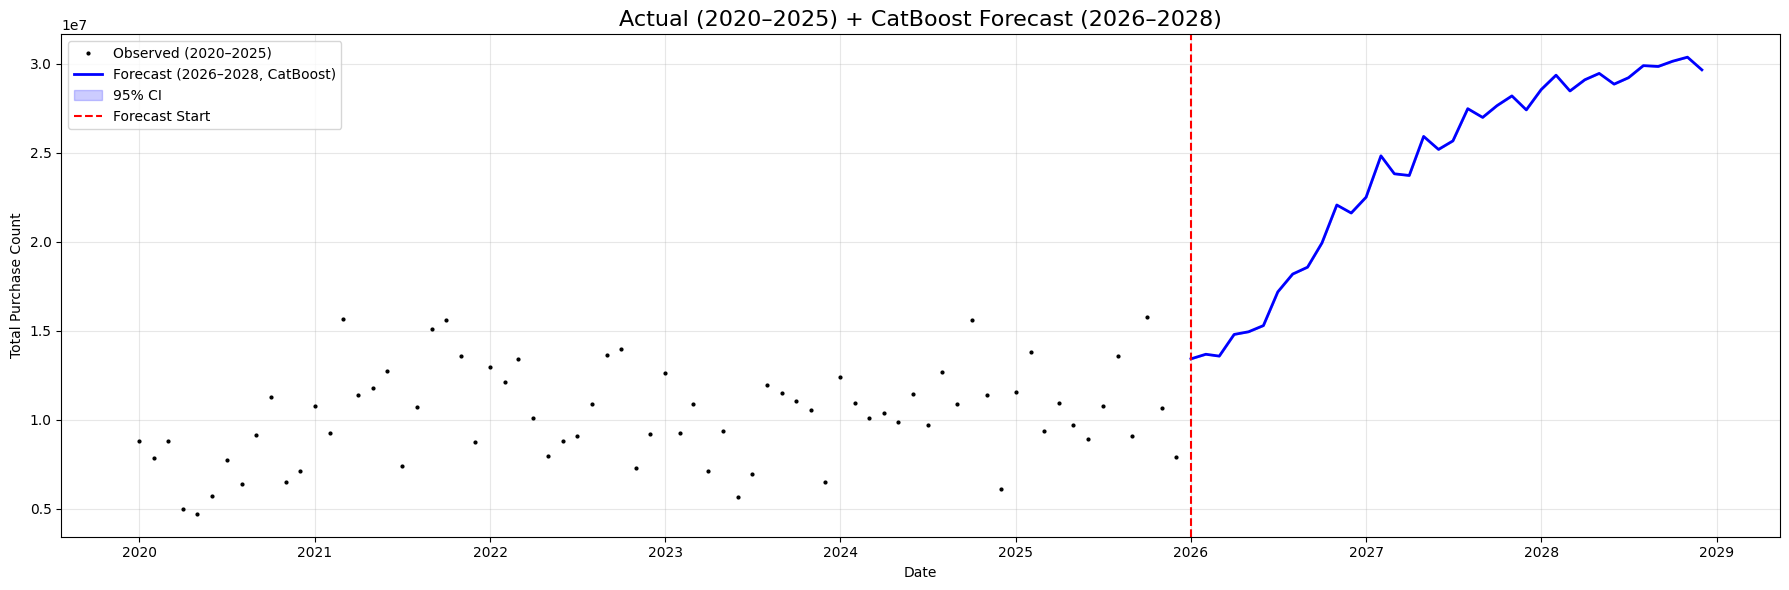

In [161]:
plt.figure(figsize=(18, 6))

# --- Actual 2020-2025 ---
monthly_hist_2020 = monthly_hist[monthly_hist["DATE"] >= "2020-01-01"]

plt.plot(
    monthly_hist_2020["DATE"],
    monthly_hist_2020["TOTAL_PURCHASE_COUNT"],
    "k.", markersize=4, label="Observed (2020–2025)"
)

# --- Forecast 2026-2028 ---
plt.plot(
    monthly_cat["DATE"],
    monthly_cat["PRED_CAT"],
    color="blue", linewidth=2, label="Forecast (2026–2028, CatBoost)"
)

# --- CI ---
plt.fill_between(
    monthly_cat["DATE"],
    monthly_cat["LOWER_CAT"],
    monthly_cat["UPPER_CAT"],
    color="blue", alpha=0.2, label="95% CI"
)

# --- Forecast Start Line ---
plt.axvline(pd.to_datetime("2026-01-01"), color="red", linestyle="--", label="Forecast Start")

plt.title("Actual (2020–2025) + CatBoost Forecast (2026–2028)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchase Count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [162]:
'''
# ========== 1. Historical Monthly Totals ==========
df_hist_all = df_final.copy()
df_hist_all["DATE"] = pd.to_datetime(df_hist_all["DATE"])

monthly_hist = (
    df_hist_all
    .groupby("DATE")["TOTAL_PURCHASE_COUNT"]
    .sum()
    .reset_index()
)

# ========== 2. Perform in-sample predictions on the historical period using the trained CatBoost model. ==========
X_hist = df_final[feature_cols].astype(float)
y_hist = df_final["TOTAL_PURCHASE_COUNT"].astype(float)

df_final_pred = df_final[["DATE"]].copy()
df_final_pred["PRED_CAT"] = model_cat.predict(X_hist)

# Aggregate row-level forecasts into a “monthly total forecast”
monthly_train_pred = (
    df_final_pred
    .groupby("DATE")["PRED_CAT"]
    .sum()
    .reset_index()
)

# Only take dates with data on both sides and calculate the total residuals.
monthly_compare = monthly_hist.merge(
    monthly_train_pred,
    on="DATE",
    how="inner"
)

residuals_monthly = (
    monthly_compare["TOTAL_PURCHASE_COUNT"] - monthly_compare["PRED_CAT"]
)

std_res_monthly = residuals_monthly.std()
print("std_res_monthly:", std_res_monthly)
'''

'\n# ========== 1. Historical Monthly Totals ==========\ndf_hist_all = df_final.copy()\ndf_hist_all["DATE"] = pd.to_datetime(df_hist_all["DATE"])\n\nmonthly_hist = (\n    df_hist_all\n    .groupby("DATE")["TOTAL_PURCHASE_COUNT"]\n    .sum()\n    .reset_index()\n)\n\n# ========== 2. Perform in-sample predictions on the historical period using the trained CatBoost model. ==========\nX_hist = df_final[feature_cols].astype(float)\ny_hist = df_final["TOTAL_PURCHASE_COUNT"].astype(float)\n\ndf_final_pred = df_final[["DATE"]].copy()\ndf_final_pred["PRED_CAT"] = model_cat.predict(X_hist)\n\n# Aggregate row-level forecasts into a “monthly total forecast”\nmonthly_train_pred = (\n    df_final_pred\n    .groupby("DATE")["PRED_CAT"]\n    .sum()\n    .reset_index()\n)\n\n# Only take dates with data on both sides and calculate the total residuals.\nmonthly_compare = monthly_hist.merge(\n    monthly_train_pred,\n    on="DATE",\n    how="inner"\n)\n\nresiduals_monthly = (\n    monthly_compare["TOTAL_P

In [163]:
'''
# --- 未来 2026–2028 的月度预测 ---
monthly_cat = (
    cat_pred_26_28
    .groupby("DATE")["PRED"]
    .sum()
    .reset_index()
)
monthly_cat.rename(columns={"PRED": "PRED_CAT"}, inplace=True)

# ===== 用“月度总量残差”的 std 来画 CI =====
k = 1.96   # 想更宽可以改成 2.5 或 3

monthly_cat["LOWER_CAT"] = monthly_cat["PRED_CAT"] - k * std_res_monthly
monthly_cat["UPPER_CAT"] = monthly_cat["PRED_CAT"] + k * std_res_monthly

# 不要出现负数
monthly_cat["LOWER_CAT"] = monthly_cat["LOWER_CAT"].clip(lower=0)
'''

'\n# --- 未来 2026–2028 的月度预测 ---\nmonthly_cat = (\n    cat_pred_26_28\n    .groupby("DATE")["PRED"]\n    .sum()\n    .reset_index()\n)\nmonthly_cat.rename(columns={"PRED": "PRED_CAT"}, inplace=True)\n\n# ===== 用“月度总量残差”的 std 来画 CI =====\nk = 1.96   # 想更宽可以改成 2.5 或 3\n\nmonthly_cat["LOWER_CAT"] = monthly_cat["PRED_CAT"] - k * std_res_monthly\nmonthly_cat["UPPER_CAT"] = monthly_cat["PRED_CAT"] + k * std_res_monthly\n\n# 不要出现负数\nmonthly_cat["LOWER_CAT"] = monthly_cat["LOWER_CAT"].clip(lower=0)\n'

In [164]:
'''
plt.figure(figsize=(18, 6))

# observed（到 2025）
plt.plot(
    monthly_hist["DATE"],
    monthly_hist["TOTAL_PURCHASE_COUNT"],
    "k.", markersize=4, label="Observed"
)

# forecast（2026–2028）
plt.plot(
    monthly_cat["DATE"],
    monthly_cat["PRED_CAT"],
    color="blue", linewidth=2, label="Forecast (CatBoost)"
)

# CI 区间
plt.fill_between(
    monthly_cat["DATE"],
    monthly_cat["LOWER_CAT"],
    monthly_cat["UPPER_CAT"],
    color="blue", alpha=0.2, label=f"{int(k*2*25)}% CI"  # k=1.96 时大约 95% CI
)

plt.axvline(pd.to_datetime("2026-01-01"), color="red", linestyle="--", label="Forecast Start")

plt.title("CatBoost Forecast (2026–2028)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchase Count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
'''

'\nplt.figure(figsize=(18, 6))\n\n# observed（到 2025）\nplt.plot(\n    monthly_hist["DATE"],\n    monthly_hist["TOTAL_PURCHASE_COUNT"],\n    "k.", markersize=4, label="Observed"\n)\n\n# forecast（2026–2028）\nplt.plot(\n    monthly_cat["DATE"],\n    monthly_cat["PRED_CAT"],\n    color="blue", linewidth=2, label="Forecast (CatBoost)"\n)\n\n# CI 区间\nplt.fill_between(\n    monthly_cat["DATE"],\n    monthly_cat["LOWER_CAT"],\n    monthly_cat["UPPER_CAT"],\n    color="blue", alpha=0.2, label=f"{int(k*2*25)}% CI"  # k=1.96 时大约 95% CI\n)\n\nplt.axvline(pd.to_datetime("2026-01-01"), color="red", linestyle="--", label="Forecast Start")\n\nplt.title("CatBoost Forecast (2026–2028)", fontsize=16)\nplt.xlabel("Date")\nplt.ylabel("Total Purchase Count")\nplt.grid(alpha=0.3)\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

In [165]:
'''
monthly_cat.head()
'''

'\nmonthly_cat.head()\n'

In [166]:
'''
# ===== 1) 训练集上 log 尺度的 RMSE（仅做参考） =====
train_pred_log = model_cat.predict(X_train)
rmse_log = np.sqrt(np.mean((y_train - train_pred_log) ** 2))
print("CatBoost train RMSE (log scale):", rmse_log)

# ===== 2) 把预测和真实都还原到“原尺度”，再算残差 std =====
y_train_raw = df_final["TOTAL_PURCHASE_COUNT"].astype(float).values          # 真实原值
train_pred_raw = np.expm1(train_pred_log)                        # 预测原值

residuals_raw = y_train_raw - train_pred_raw                     # 每行残差（原尺度）
std_res_row = residuals_raw.std()                                # 用于 CI 的 std

print("Row-level residual std (raw scale):", std_res_row)
'''

'\n# ===== 1) 训练集上 log 尺度的 RMSE（仅做参考） =====\ntrain_pred_log = model_cat.predict(X_train)\nrmse_log = np.sqrt(np.mean((y_train - train_pred_log) ** 2))\nprint("CatBoost train RMSE (log scale):", rmse_log)\n\n# ===== 2) 把预测和真实都还原到“原尺度”，再算残差 std =====\ny_train_raw = df_final["TOTAL_PURCHASE_COUNT"].astype(float).values          # 真实原值\ntrain_pred_raw = np.expm1(train_pred_log)                        # 预测原值\n\nresiduals_raw = y_train_raw - train_pred_raw                     # 每行残差（原尺度）\nstd_res_row = residuals_raw.std()                                # 用于 CI 的 std\n\nprint("Row-level residual std (raw scale):", std_res_row)\n'

In [167]:
'''
import numpy as np

k = 1.96   # 95% CI，可以改成 2.5 / 3 来加宽

cat_pred_26_28 = cat_pred_26_28.copy()

cat_pred_26_28["PRED_LOWER"] = cat_pred_26_28["PRED"] - k * std_res_row
cat_pred_26_28["PRED_UPPER"] = cat_pred_26_28["PRED"] + k * std_res_row

# 不允许负数
cat_pred_26_28["PRED_LOWER"] = cat_pred_26_28["PRED_LOWER"].clip(lower=0.0)
'''

'\nimport numpy as np\n\nk = 1.96   # 95% CI，可以改成 2.5 / 3 来加宽\n\ncat_pred_26_28 = cat_pred_26_28.copy()\n\ncat_pred_26_28["PRED_LOWER"] = cat_pred_26_28["PRED"] - k * std_res_row\ncat_pred_26_28["PRED_UPPER"] = cat_pred_26_28["PRED"] + k * std_res_row\n\n# 不允许负数\ncat_pred_26_28["PRED_LOWER"] = cat_pred_26_28["PRED_LOWER"].clip(lower=0.0)\n'

In [168]:
cat_pred_26_28.head()

,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,SEASON,YEAR,MONTH,PRED,DATE
0,0,3,5,0,3,4,0,2026,1,234,2026-01-01
1,0,3,5,0,3,4,0,2026,2,63,2026-02-01
2,0,3,5,0,3,4,0,2026,3,32,2026-03-01
3,0,3,5,0,3,4,0,2026,4,39,2026-04-01
4,0,3,5,0,3,4,0,2026,5,16,2026-05-01


合并quantile与RMSE

In [169]:
pred_all = cat_pred_26_28.head()
# 1. Rename the RMSE prediction column
pred_rmse = cat_pred_26_28.rename(columns={"PRED": "PRED_RMSE"})

# 2. Merge quantile forecasts by key; values exist only for 2026–2028, with historical portions marked as NaN
key_cols = group_cols + ["YEAR", "MONTH"]

pred_all_full = pred_rmse.merge(
    mq_pred_26_28[key_cols + ["PRED_p50", "PRED_p05", "PRED_p95"]],
    on=key_cols,
    how="left"
)

if "DATE" not in pred_all_full.columns:
    pred_all_full["DATE"] = pd.to_datetime(
        pred_all_full["YEAR"].astype(str) + "-" +
        pred_all_full["MONTH"].astype(str) + "-01"
    )

# order
pred_all_full = pred_all_full.sort_values(key_cols + ["DATE"]).reset_index(drop=True)

In [170]:
print(pred_all_full.isna().sum())
print(pred_all_full.columns)
print(pred_all_full.head())

REGION        0
COUNTRY       0
SALESORG      0
SILHOUETTE    0
GENDER        0
SPORT         0
SEASON        0
YEAR          0
MONTH         0
PRED_RMSE     0
DATE          0
PRED_p50      0
PRED_p05      0
PRED_p95      0
dtype: int64
Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'PRED_RMSE', 'DATE', 'PRED_p50', 'PRED_p05',
       'PRED_p95'],
      dtype='object')
   REGION  COUNTRY  SALESORG  SILHOUETTE  GENDER  SPORT  SEASON  YEAR  MONTH  \
0       0        3         5           0       3      4       0  2026      1   
1       0        3         5           0       3      4       0  2026      2   
2       0        3         5           0       3      4       0  2026      3   
3       0        3         5           0       3      4       0  2026      4   
4       0        3         5           0       3      4       0  2026      5   

   PRED_RMSE       DATE  PRED_p50  PRED_p05  PRED_p95  
0        234 2026-01-01       23

In [171]:
#pred_all_full.to_csv("pred_all_2026_2028.csv", index=False)

## retrain 2025

In [172]:
train = df_clean[df_clean["YEAR"] <= 2024]
test  = df_clean[df_clean["YEAR"] == 2025]
target_col = "TOTAL_PURCHASE_COUNT"

train_df = df_final[df_final["YEAR"] <= 2024].copy()
test_df  = df_final[df_final["YEAR"] == 2025].copy()

X_train = train_df[feature_cols].astype(float)
y_train = train_df[target_col].astype(float)

X_test  = test_df[feature_cols].astype(float)
y_test  = test_df[target_col].astype(float)


### train for 2025
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    depth=8,
    learning_rate=0.05,
    random_seed=42,
    subsample=0.8,
    colsample_bylevel=0.8,
    od_type='Iter',
    od_wait=50,
    verbose=100
)

model_cat.fit(X_train, y_train)
pred_2025 = model_cat.predict(X_test)

model_p50 = CatBoostRegressor(
    loss_function='Quantile:alpha=0.5',
    iterations=800,
    depth=8,
    learning_rate=0.05,
    random_seed=42,
    verbose=100
)
model_p50.fit(X_train, y_train)
pred_2025_p50 = model_p50.predict(X_test)

model_p05 = CatBoostRegressor(
    loss_function='Quantile:alpha=0.05',
    iterations=800,
    depth=8,
    learning_rate=0.05,
    random_seed=42,
    verbose=100
)
model_p05.fit(X_train, y_train)
pred_2025_p05 = model_p05.predict(X_test)



model_p95 = CatBoostRegressor(
    loss_function='Quantile:alpha=0.95',
    iterations=800,
    depth=8,
    learning_rate=0.05,
    random_seed=42,
    verbose=100
)
model_p95.fit(X_train, y_train)
pred_2025_p95 = model_p95.predict(X_test)





from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ---------- Basic metrics ----------
mae  = mean_absolute_error(y_test, pred_2025)

mse  = mean_squared_error(y_test, pred_2025)
rmse = np.sqrt(mse)

mape = (np.abs(pred_2025 - y_test) / (y_test + 1e-9)).mean()

# ---------- SMAPE ----------
smape = (
    np.abs(pred_2025 - y_test) /
    ((np.abs(y_test) + np.abs(pred_2025)) / 2 + 1e-9)
).mean() * 100

# ---------- R² ----------
r2 = r2_score(y_test, pred_2025)

# ---------- MASE ----------

# 构造 naive seasonal forecast
y_test_shift = y_test.shift(12)
naive_mae = np.mean(np.abs(y_test[12:] - y_test_shift[12:]))
mase = mae / (naive_mae + 1e-9)

# --------------------
print("===== Validation Metrics (2025) =====")
print(f"MAE   : {mae:,.2f}")
print(f"RMSE  : {rmse:,.2f}")
print(f"MSE   : {mse:,.2f}")
print(f"MAPE  : {mape*100:.2f}%")
print(f"SMAPE : {smape:.2f}%")
print(f"R²    : {r2:.4f}")
print(f"MASE  : {mase:.4f}")

0:	learn: 302552.4570494	total: 29.6ms	remaining: 29.6s
100:	learn: 35349.4301672	total: 1.42s	remaining: 12.6s
200:	learn: 22621.7790958	total: 2.66s	remaining: 10.6s
300:	learn: 17120.8936359	total: 3.96s	remaining: 9.21s
400:	learn: 13420.0683187	total: 5.28s	remaining: 7.89s
500:	learn: 11418.7470950	total: 6.54s	remaining: 6.51s
600:	learn: 9637.8650204	total: 7.95s	remaining: 5.28s
700:	learn: 8433.2397428	total: 9.18s	remaining: 3.92s
800:	learn: 7243.9299636	total: 10.4s	remaining: 2.59s
900:	learn: 6285.9631862	total: 11.8s	remaining: 1.3s
999:	learn: 5506.8362429	total: 13s	remaining: 0us
0:	learn: 11063.2604223	total: 17.7ms	remaining: 14.2s
100:	learn: 8132.2498247	total: 1.47s	remaining: 10.2s
200:	learn: 3199.5001692	total: 3.02s	remaining: 8.99s
300:	learn: 2696.7319908	total: 4.48s	remaining: 7.43s
400:	learn: 2461.2513791	total: 6.06s	remaining: 6.03s
500:	learn: 2289.0876621	total: 7.53s	remaining: 4.49s
600:	learn: 2190.0620828	total: 9.09s	remaining: 3.01s
700:	lear

In [173]:
residual_2025 = y_test - pred_2025
sigma = residual_2025.std()
print("sigma_2025 =", sigma)


sigma_2025 = 71057.01032642432


In [174]:
pred = pred_all_full["PRED_RMSE"]
pred_all_full["LOWER_RMSE_CI"] = (pred - 1.96 * sigma).clip(lower=0)
pred_all_full["UPPER_RMSE_CI"] = pred + 1.96 * sigma

In [175]:
print(pred_all_full.head())

   REGION  COUNTRY  SALESORG  SILHOUETTE  GENDER  SPORT  SEASON  YEAR  MONTH  \
0       0        3         5           0       3      4       0  2026      1   
1       0        3         5           0       3      4       0  2026      2   
2       0        3         5           0       3      4       0  2026      3   
3       0        3         5           0       3      4       0  2026      4   
4       0        3         5           0       3      4       0  2026      5   

   PRED_RMSE       DATE  PRED_p50  PRED_p05  PRED_p95  LOWER_RMSE_CI  \
0        234 2026-01-01       232       205       248              0   
1         63 2026-02-01        58        44        67              0   
2         32 2026-03-01        21        13        28              0   
3         39 2026-04-01        34        23        41              0   
4         16 2026-05-01        10         6        17              0   

   UPPER_RMSE_CI  
0        139,506  
1        139,334  
2        139,303  
3        1

In [176]:
y_train.head()

0     288
1   1,126
2   1,900
3     400
4     144
Name: TOTAL_PURCHASE_COUNT, dtype: float64

In [177]:
validate_2025 = test_df.copy() 

validate_2025["PRED_RMSE"] = pred_2025
validate_2025["PRED_p50"]  = pred_2025_p50
validate_2025["PRED_p05"]  = pred_2025_p05
validate_2025["PRED_p95"]  = pred_2025_p95

In [178]:
validate_2025.isna().sum()

REGION                     0
COUNTRY                    0
SALESORG                   0
SILHOUETTE                 0
GENDER                     0
SPORT                      0
SEASON                     0
YEAR                       0
MONTH                      0
TOTAL_PURCHASE_COUNT       0
DATE                       0
LAG_1                     65
LAG_3                    207
LAG_6                    384
LAG_12                   703
LAG_24                  1445
ROLL_MEAN_3               65
ROLL_MEAN_6               65
Y_LOG                      0
MONTH_SIN                  0
MONTH_COS                  0
YEAR_INDEX                 0
ANCHOR_MEAN_3             65
ANCHOR_MEAN_6             65
ANCHOR_DYNAMIC            65
TREND_3                  207
TREND_6                  384
TREND_RATE_3             207
YOY_CHANGE                 0
PRED_RMSE                  0
PRED_p50                   0
PRED_p05                   0
PRED_p95                   0
dtype: int64

In [179]:
validate_2025.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'TOTAL_PURCHASE_COUNT', 'DATE', 'LAG_1',
       'LAG_3', 'LAG_6', 'LAG_12', 'LAG_24', 'ROLL_MEAN_3', 'ROLL_MEAN_6',
       'Y_LOG', 'MONTH_SIN', 'MONTH_COS', 'YEAR_INDEX', 'ANCHOR_MEAN_3',
       'ANCHOR_MEAN_6', 'ANCHOR_DYNAMIC', 'TREND_3', 'TREND_6', 'TREND_RATE_3',
       'YOY_CHANGE', 'PRED_RMSE', 'PRED_p50', 'PRED_p05', 'PRED_p95'],
      dtype='object')

In [180]:
keep_cols = [
    'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
    'SEASON', 'YEAR', 'MONTH', 'TOTAL_PURCHASE_COUNT', 'DATE',
    'PRED_RMSE',
     'PRED_p50', 'PRED_p05', 'PRED_p95'
]
keep_cols_2628 = [
    'REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
    'SEASON', 'YEAR', 'MONTH', 'DATE',
    'PRED_RMSE',
     'PRED_p50', 'PRED_p05', 'PRED_p95'
]

In [181]:
validate_2025_clean = validate_2025[keep_cols].copy()

In [182]:
pred_all_full_updated=pred_all_full[keep_cols_2628].copy()

In [183]:
validate_2025_clean.head()

,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,SEASON,YEAR,MONTH,TOTAL_PURCHASE_COUNT,DATE,PRED_RMSE,PRED_p50,PRED_p05,PRED_p95
8,0,3,5,0,3,4,1,2025,2,150,2025-02-01,124,149,140,330
9,0,3,5,0,3,4,1,2025,8,315,2025-08-01,162,307,269,"1,232"
13,0,3,5,1,3,4,1,2025,8,100,2025-08-01,743,128,1,"3,620"
14,0,3,5,1,3,4,1,2025,9,545,2025-09-01,635,146,-0,"3,583"
15,0,3,5,1,3,4,1,2025,11,195,2025-11-01,580,238,6,"3,677"


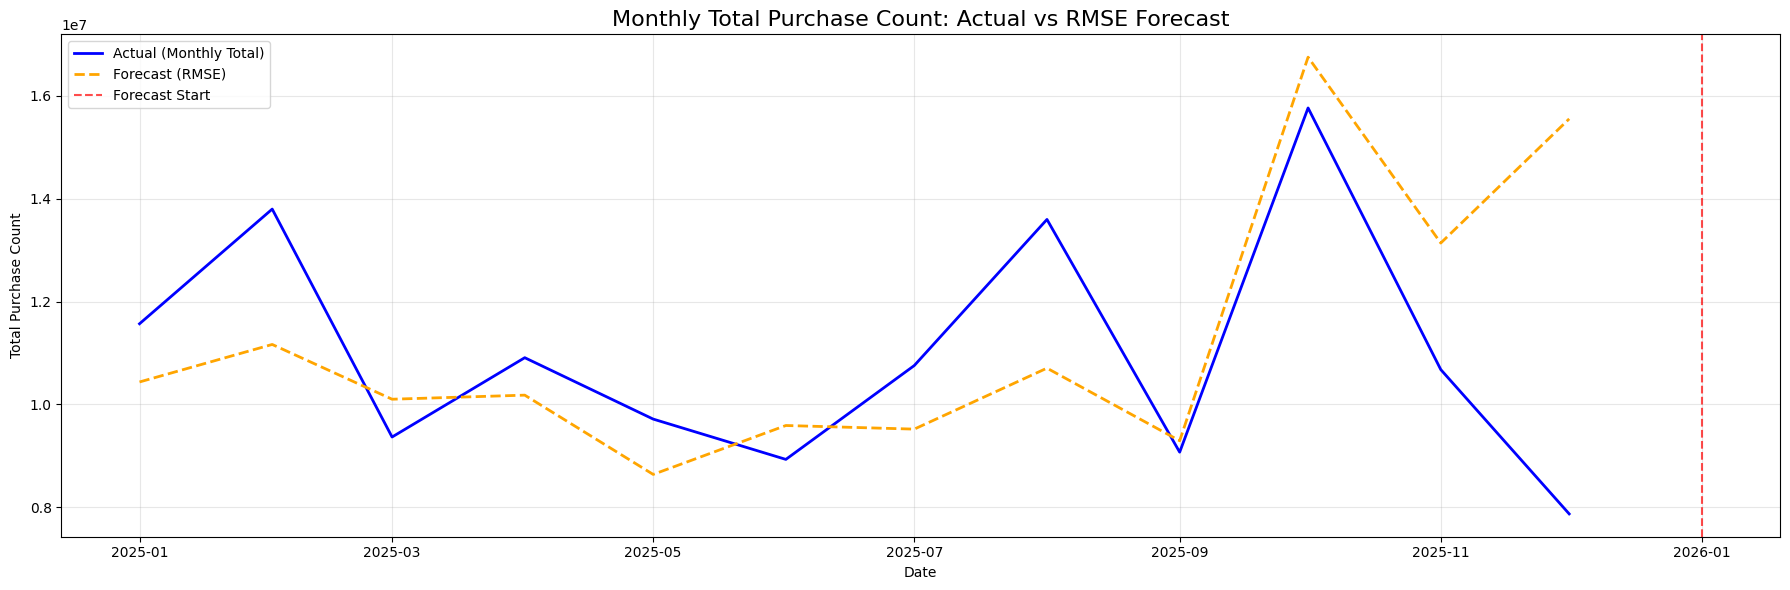

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

df_plot_temp = validate_2025_clean.copy()
df_plot_temp["DATE"] = pd.to_datetime(df_plot_temp["DATE"])

# Monthly Aggregate Total
monthly_total_temp = (
    df_plot_temp
    .groupby("DATE")[["TOTAL_PURCHASE_COUNT", "PRED_RMSE"]]
    .sum()
    .reset_index()
    .sort_values("DATE")
)
plt.figure(figsize=(18, 6))

# actual
plt.plot(
    monthly_total_temp["DATE"],
    monthly_total_temp["TOTAL_PURCHASE_COUNT"],
    color="blue",
    linewidth=2,
    label="Actual (Monthly Total)"
)

# RMSE
plt.plot(
    monthly_total_temp["DATE"],
    monthly_total_temp["PRED_RMSE"],
    color="orange",
    linewidth=2,
    linestyle="--",
    label="Forecast (RMSE)"
)

# Starting Point 
plt.axvline(
    pd.to_datetime("2026-01-01"),
    color="red",
    linestyle="--",
    alpha=0.7,
    label="Forecast Start"
)

plt.title("Monthly Total Purchase Count: Actual vs RMSE Forecast", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchase Count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [185]:
pred_all_full_updated.head()

,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,SEASON,YEAR,MONTH,DATE,PRED_RMSE,PRED_p50,PRED_p05,PRED_p95
0,0,3,5,0,3,4,0,2026,1,2026-01-01,234,232,205,248
1,0,3,5,0,3,4,0,2026,2,2026-02-01,63,58,44,67
2,0,3,5,0,3,4,0,2026,3,2026-03-01,32,21,13,28
3,0,3,5,0,3,4,0,2026,4,2026-04-01,39,34,23,41
4,0,3,5,0,3,4,0,2026,5,2026-05-01,16,10,6,17


In [186]:
pred_all_full_updated["YEAR"].unique()

array([2026, 2027, 2028])

In [187]:
pred_all_full_no2025 = pred_all_full_updated[pred_all_full_updated["YEAR"] != 2025].copy()
pred_all_full_final = pd.concat(
    [pred_all_full_no2025, validate_2025_clean],
    axis=0,
    ignore_index=True
)
pred_all_full_final = pred_all_full_final.sort_values(
    by= ['REGION','COUNTRY','SALESORG','SILHOUETTE','GENDER','SPORT',
         'SEASON','YEAR','MONTH']
).reset_index(drop=True)

In [188]:
pred_all_full_final.isna().sum()

REGION                      0
COUNTRY                     0
SALESORG                    0
SILHOUETTE                  0
GENDER                      0
SPORT                       0
SEASON                      0
YEAR                        0
MONTH                       0
DATE                        0
PRED_RMSE                   0
PRED_p50                    0
PRED_p05                    0
PRED_p95                    0
TOTAL_PURCHASE_COUNT    89100
dtype: int64

In [189]:
len(pred_all_full_final)

95909

In [190]:
missing_rows = pred_all_full_final[pred_all_full_final.isna().any(axis=1)]
missing_rows.head()

,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,SEASON,YEAR,MONTH,DATE,PRED_RMSE,PRED_p50,PRED_p05,PRED_p95,TOTAL_PURCHASE_COUNT
0,0,3,5,0,3,4,0,2026,1,2026-01-01,234,232,205,248,NaN
1,0,3,5,0,3,4,0,2026,2,2026-02-01,63,58,44,67,NaN
2,0,3,5,0,3,4,0,2026,3,2026-03-01,32,21,13,28,NaN
3,0,3,5,0,3,4,0,2026,4,2026-04-01,39,34,23,41,NaN
4,0,3,5,0,3,4,0,2026,5,2026-05-01,16,10,6,17,NaN


In [191]:
missing_rows["YEAR"].value_counts().sort_index()

2026    29700
2027    29700
2028    29700
Name: YEAR, dtype: Int64

In [192]:
pred_all_full_final["PI_WIDTH"]=pred_all_full_final["PRED_p95"]-pred_all_full_final["PRED_p05"]
pred_all_full_final["CI_UPPER"]=pred_all_full_final["PRED_p95"]
pred_all_full_final["CI_LOWER"]=pred_all_full_final["PRED_p05"]

In [193]:
pred_all_full_final.columns
print(pred_all_full_final.head())

   REGION  COUNTRY  SALESORG  SILHOUETTE  GENDER  SPORT  SEASON  YEAR  MONTH  \
0       0        3         5           0       3      4       0  2026      1   
1       0        3         5           0       3      4       0  2026      2   
2       0        3         5           0       3      4       0  2026      3   
3       0        3         5           0       3      4       0  2026      4   
4       0        3         5           0       3      4       0  2026      5   

        DATE  PRED_RMSE  PRED_p50  PRED_p05  PRED_p95  TOTAL_PURCHASE_COUNT  \
0 2026-01-01        234       232       205       248                   NaN   
1 2026-02-01         63        58        44        67                   NaN   
2 2026-03-01         32        21        13        28                   NaN   
3 2026-04-01         39        34        23        41                   NaN   
4 2026-05-01         16        10         6        17                   NaN   

   PI_WIDTH  CI_UPPER  CI_LOWER  
0        4

In [194]:
import numpy as np
cat_cols = [
    "REGION", "COUNTRY", "SALESORG", "SILHOUETTE",
    "PRODUCT_DIVISION", "GENDER", "SPORT", "SEASON"
]
for col in cat_cols:
    if col not in label_encoders:
        print(f"[WARN] {col} 不在 label_encoders 里，跳过。")
        continue
    
    le = label_encoders[col]
    
    codes = pred_all_full_final[col].values
    
    # NaN
    mask_notna = ~pd.isna(codes)
    codes_int = codes.copy()
    codes_int[mask_notna] = np.round(codes_int[mask_notna]).astype("int64")
    
    decoded = np.full_like(codes, fill_value=np.nan, dtype="object")
    decoded[mask_notna] = le.inverse_transform(codes_int[mask_notna].astype("int64"))
    
    # REGION_DECODED
    pred_all_full_final[col + "_DECODED"] = decoded

[WARN] PRODUCT_DIVISION 不在 label_encoders 里，跳过。


In [195]:
pred_all_full_final.head()

,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,SEASON,YEAR,MONTH,DATE,...,PI_WIDTH,CI_UPPER,CI_LOWER,REGION_DECODED,COUNTRY_DECODED,SALESORG_DECODED,SILHOUETTE_DECODED,GENDER_DECODED,SPORT_DECODED,SEASON_DECODED
0,0,3,5,0,3,4,0,2026,1,2026-01-01,...,43,248,205,EMEA,Germany,German,3930,Male,Others,Custom
1,0,3,5,0,3,4,0,2026,2,2026-02-01,...,23,67,44,EMEA,Germany,German,3930,Male,Others,Custom
2,0,3,5,0,3,4,0,2026,3,2026-03-01,...,15,28,13,EMEA,Germany,German,3930,Male,Others,Custom
3,0,3,5,0,3,4,0,2026,4,2026-04-01,...,18,41,23,EMEA,Germany,German,3930,Male,Others,Custom
4,0,3,5,0,3,4,0,2026,5,2026-05-01,...,12,17,6,EMEA,Germany,German,3930,Male,Others,Custom


In [196]:
col = "REGION"
le = label_encoders[col]

codes = np.unique(pred_all_full_final[col].dropna().round().astype("int64"))
unknown = np.setdiff1d(codes, le.classes_)

print("unknown：", unknown)

unknown： [0 1 2 3 4]


In [197]:
decode_cols = [
    "REGION_DECODED", "COUNTRY_DECODED", "SALESORG_DECODED",
    "SILHOUETTE_DECODED", "GENDER_DECODED", "SPORT_DECODED", "SEASON_DECODED"
]

for col in decode_cols:
    print(f"\n===== {col} =====")

    if col not in pred_all_full_final.columns:
        print("⚠️ skip")
        continue

    unique_vals = pred_all_full_final[col].unique()
    n_unique = pred_all_full_final[col].nunique(dropna=True)
    n_nan = pred_all_full_final[col].isna().sum()

    print(f"Number of unique values: {n_unique}")
    print(f"Number of Missing Values: {n_nan}")
    print("Unique Value List:")
    print(unique_vals)


===== REGION_DECODED =====
Number of unique values: 5
Number of Missing Values: 0
Unique Value List:
['EMEA' 'Emerging Markets' 'Japan' 'North America' 'Unknown']

===== COUNTRY_DECODED =====
Number of unique values: 12
Number of Missing Values: 0
Unique Value List:
['Germany' 'United Kingdom' 'Australia' 'China' 'Hong Kong' 'Mexico'
 'New Zealand' 'South Korea' 'USA' 'Japan' 'Canada' 'Unknown']

===== SALESORG_DECODED =====
Number of unique values: 14
Number of Missing Values: 0
Unique Value List:
['German' 'EMEA' 'Australia' 'China' 'Southeast Asia' 'Mexico'
 'New Zealand' 'South Korea' 'Latin America' 'Japan' 'Canada'
 '5th & Ocean' 'United States' 'Unknown']

===== SILHOUETTE_DECODED =====
Number of unique values: 7
Number of Missing Values: 0
Unique Value List:
['3930' '5950' '920' '940' '950' 'Apparel' 'Others']

===== GENDER_DECODED =====
Number of unique values: 5
Number of Missing Values: 0
Unique Value List:
['Male' 'Boys' 'Others' 'Girls' 'Ladies']

===== SPORT_DECODED ====

In [198]:
cat_cols = [
    "REGION", "COUNTRY", "SALESORG", "SILHOUETTE",
    "GENDER", "SPORT", "SEASON"
]

#  *_DECODED
for col in cat_cols:
    decoded_col = col + "_DECODED"
    if decoded_col in pred_all_full_final.columns:
        pred_all_full_final[col] = pred_all_full_final[decoded_col]
    else:
        print(f"[WARN] {decoded_col} 不存在，跳过。")

decoded_cols_to_drop = [c + "_DECODED" for c in cat_cols if c + "_DECODED" in pred_all_full_final.columns]
pred_all_full_final = pred_all_full_final.drop(columns=decoded_cols_to_drop)

pred_all_full_final.head()

,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,SEASON,YEAR,MONTH,DATE,PRED_RMSE,PRED_p50,PRED_p05,PRED_p95,TOTAL_PURCHASE_COUNT,PI_WIDTH,CI_UPPER,CI_LOWER
0,EMEA,Germany,German,3930,Male,Others,Custom,2026,1,2026-01-01,234,232,205,248,NaN,43,248,205
1,EMEA,Germany,German,3930,Male,Others,Custom,2026,2,2026-02-01,63,58,44,67,NaN,23,67,44
2,EMEA,Germany,German,3930,Male,Others,Custom,2026,3,2026-03-01,32,21,13,28,NaN,15,28,13
3,EMEA,Germany,German,3930,Male,Others,Custom,2026,4,2026-04-01,39,34,23,41,NaN,18,41,23
4,EMEA,Germany,German,3930,Male,Others,Custom,2026,5,2026-05-01,16,10,6,17,NaN,12,17,6


In [199]:
cols_to_check = ["PRED_RMSE","PRED_p50", "PRED_p05", "PRED_p95", "TOTAL_PURCHASE_COUNT"]

neg_counts = (pred_all_full_final[cols_to_check] < 0).sum()
neg_counts

PRED_RMSE               1864
PRED_p50                2446
PRED_p05                3454
PRED_p95                  94
TOTAL_PURCHASE_COUNT       0
dtype: int64

In [200]:
pred_all_full_final[cols_to_check] = pred_all_full_final[cols_to_check].clip(lower=0)

In [201]:
pred_all_full_final.head()

,REGION,COUNTRY,SALESORG,SILHOUETTE,GENDER,SPORT,SEASON,YEAR,MONTH,DATE,PRED_RMSE,PRED_p50,PRED_p05,PRED_p95,TOTAL_PURCHASE_COUNT,PI_WIDTH,CI_UPPER,CI_LOWER
0,EMEA,Germany,German,3930,Male,Others,Custom,2026,1,2026-01-01,234,232,205,248,NaN,43,248,205
1,EMEA,Germany,German,3930,Male,Others,Custom,2026,2,2026-02-01,63,58,44,67,NaN,23,67,44
2,EMEA,Germany,German,3930,Male,Others,Custom,2026,3,2026-03-01,32,21,13,28,NaN,15,28,13
3,EMEA,Germany,German,3930,Male,Others,Custom,2026,4,2026-04-01,39,34,23,41,NaN,18,41,23
4,EMEA,Germany,German,3930,Male,Others,Custom,2026,5,2026-05-01,16,10,6,17,NaN,12,17,6


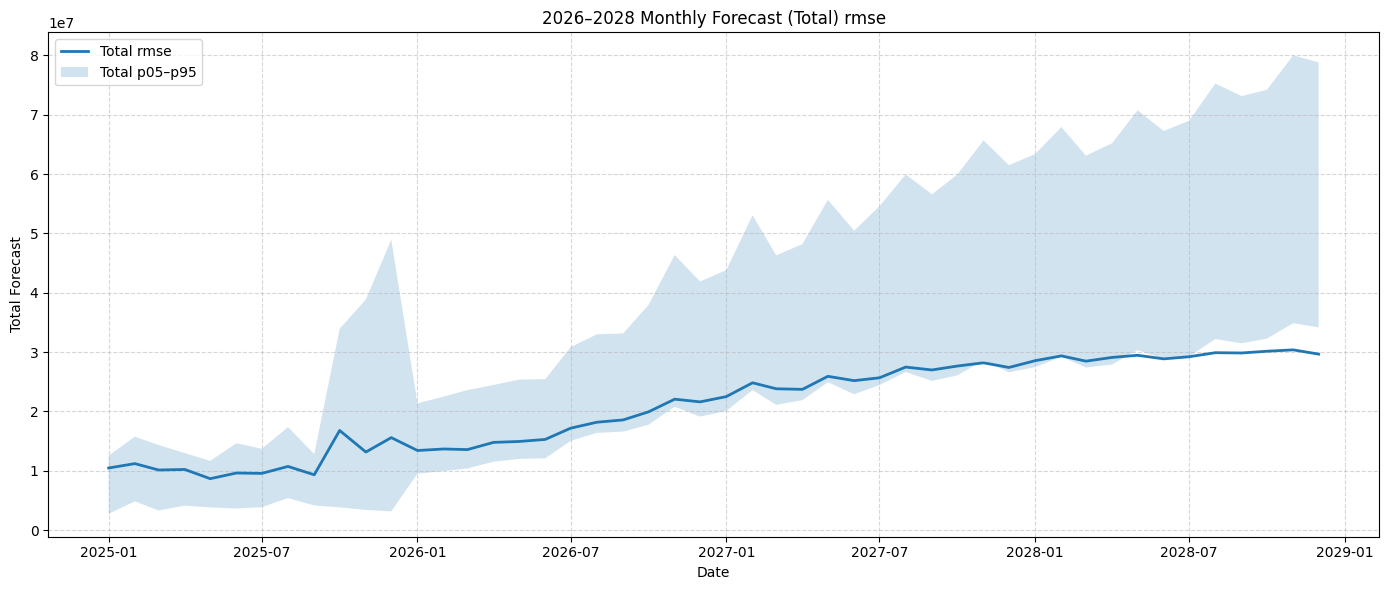

In [202]:
import matplotlib.pyplot as plt

# 1. agg
monthly_26_28 = (
    pred_all_full_final
    .groupby("DATE")
    .agg({
        "PRED_RMSE": "sum",
        "PRED_p05": "sum",
        "PRED_p50": "sum",
        "PRED_p95": "sum"
    })
    .reset_index()
)

# 2. p50 + p05–p95
plt.figure(figsize=(14,6))

# p50 
plt.plot(
    monthly_26_28["DATE"],
    monthly_26_28["PRED_RMSE"],
    label="Total rmse",
    linewidth=2
)

# p05–p95
plt.fill_between(
    monthly_26_28["DATE"],
    monthly_26_28["PRED_p05"],
    monthly_26_28["PRED_p95"],
    alpha=0.2,
    label="Total p05–p95"
)



plt.title("2026–2028 Monthly Forecast (Total) rmse")
plt.xlabel("Date")
plt.ylabel("Total Forecast")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [203]:
pred_all_full_final.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'DATE', 'PRED_RMSE', 'PRED_p50', 'PRED_p05',
       'PRED_p95', 'TOTAL_PURCHASE_COUNT', 'PI_WIDTH', 'CI_UPPER', 'CI_LOWER'],
      dtype='object')

In [204]:
##rename
pred_all_full_final = pred_all_full_final.rename(columns={
    "PRED_RMSE": "FORECAST_RMSE",
    "PRED_p50": "FORECAST_P50",
    "PRED_p05": "FORECAST_P05",
    "PRED_p95": "FORECAST_P95",
    "TOTAL_PURCHASE_COUNT": "ACTUAL_PURCHASE",
    "PI_WIDTH": "CI_WIDTH",
    "YEAR":"FORECAST_YEAR"
})


In [205]:
pred_all_full_final.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'FORECAST_YEAR', 'MONTH', 'DATE', 'FORECAST_RMSE',
       'FORECAST_P50', 'FORECAST_P05', 'FORECAST_P95', 'ACTUAL_PURCHASE',
       'CI_WIDTH', 'CI_UPPER', 'CI_LOWER'],
      dtype='object')

In [206]:
top15_p50 = pred_all_full_final.sort_values(["FORECAST_P50"], ascending=False).head(15)

In [207]:

#pred_all_full_final.to_csv("pred_final.csv", index=False)

In [208]:
pred_all_full_final.dtypes

REGION                     object
COUNTRY                    object
SALESORG                   object
SILHOUETTE                 object
GENDER                     object
SPORT                      object
SEASON                     object
FORECAST_YEAR               Int64
MONTH                       Int64
DATE               datetime64[ns]
FORECAST_RMSE             float64
FORECAST_P50              float64
FORECAST_P05              float64
FORECAST_P95              float64
ACTUAL_PURCHASE           float64
CI_WIDTH                  float64
CI_UPPER                  float64
CI_LOWER                  float64
dtype: object

In [209]:
df_result = pred_all_full_final.copy()

print(df_result.columns)
print(df_result.head())

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'FORECAST_YEAR', 'MONTH', 'DATE', 'FORECAST_RMSE',
       'FORECAST_P50', 'FORECAST_P05', 'FORECAST_P95', 'ACTUAL_PURCHASE',
       'CI_WIDTH', 'CI_UPPER', 'CI_LOWER'],
      dtype='object')
  REGION  COUNTRY SALESORG SILHOUETTE GENDER   SPORT  SEASON  FORECAST_YEAR  \
0   EMEA  Germany   German       3930   Male  Others  Custom           2026   
1   EMEA  Germany   German       3930   Male  Others  Custom           2026   
2   EMEA  Germany   German       3930   Male  Others  Custom           2026   
3   EMEA  Germany   German       3930   Male  Others  Custom           2026   
4   EMEA  Germany   German       3930   Male  Others  Custom           2026   

   MONTH       DATE  FORECAST_RMSE  FORECAST_P50  FORECAST_P05  FORECAST_P95  \
0      1 2026-01-01            234           232           205           248   
1      2 2026-02-01             63            58            44            67   
2   

In [210]:
keep_cols=['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'FORECAST_YEAR', 'MONTH', 'DATE', 'FORECAST_RMSE','ACTUAL_PURCHASE']


In [211]:
import numpy as np
from scipy.stats import norm

df_final_result=df_result[keep_cols].copy()

# 95% CI multiplier
z = norm.ppf(0.975)   # = 1.96
sigma = 500

# Add CI columns
df_final_result["CI_LOWER"] = df_final_result["FORECAST_RMSE"] - z * sigma
df_final_result["CI_UPPER"] = df_final_result["FORECAST_RMSE"] + z * sigma


In [212]:
# rename

df_final_result = df_final_result.rename(columns={
    "FORECAST_YEAR": "YEAR",
    "FORECAST_RMSE": "FORECAST_PURCHASE"
})

In [213]:
df_final_result["SPORT"] = df_final_result["SPORT"].replace({
    "SP-None": "None"
    
})
df_final_result["GENDER"] = df_final_result["GENDER"].replace({
    "Ladies": "Women",
    "Male": "Men"
    
})


In [214]:
df_final_result["FORECAST_PURCHASE"].sum()

1001011225.900578

In [215]:
df_final_result["CI_LOWER"] = df_final_result["CI_LOWER"].clip(lower=0)
df_final_result["FORECAST_PURCHASE"] = df_final_result["FORECAST_PURCHASE"].clip(lower=0)

In [216]:
df_final_result.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'DATE', 'FORECAST_PURCHASE',
       'ACTUAL_PURCHASE', 'CI_LOWER', 'CI_UPPER'],
      dtype='object')

In [217]:
df_final_result.to_csv("purchase_final.csv", index=False)

In [218]:
df_final_result.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'DATE', 'FORECAST_PURCHASE',
       'ACTUAL_PURCHASE', 'CI_LOWER', 'CI_UPPER'],
      dtype='object')

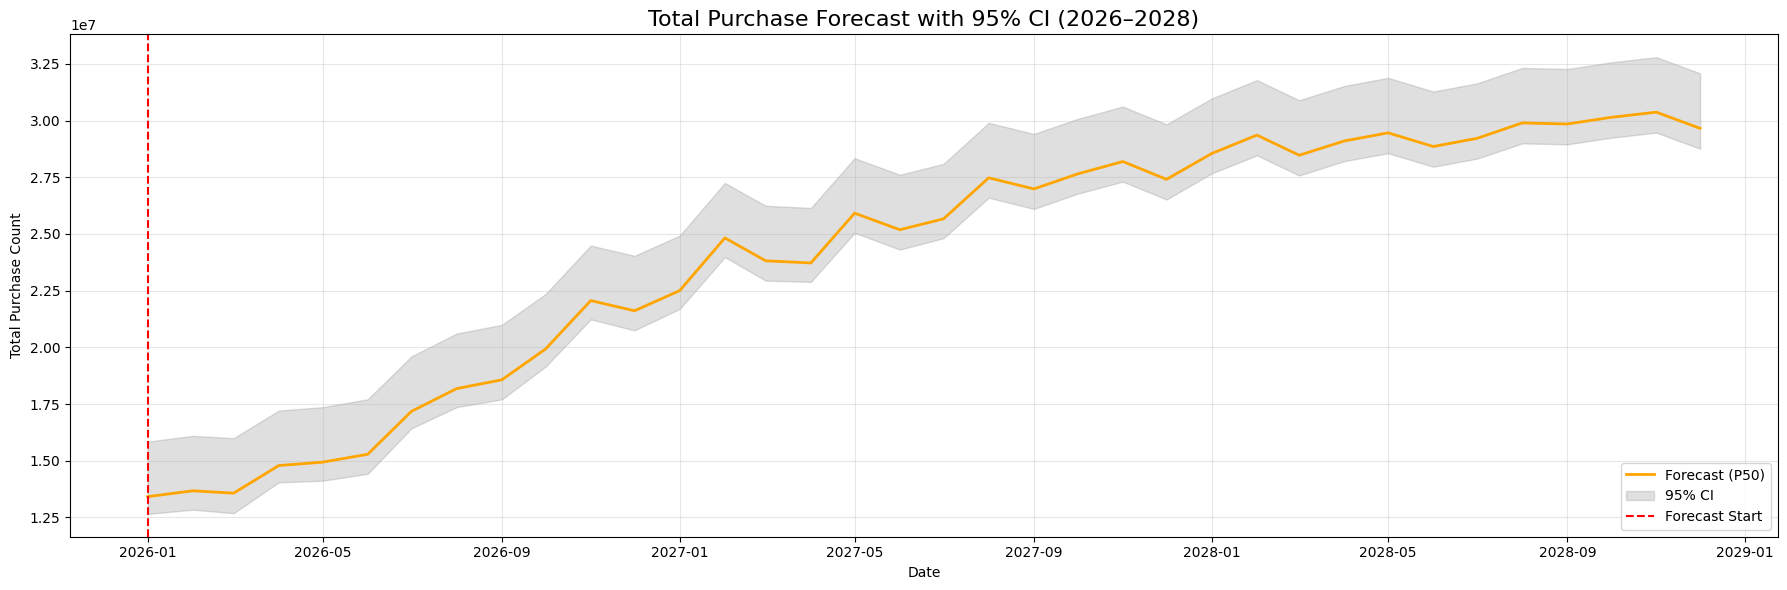

In [219]:
import matplotlib.pyplot as plt
import pandas as pd
df_plot= df_final_result.copy()

df_plot["DATE"] = pd.to_datetime(df_plot["DATE"])

# --- agg ---
df_total = (
    df_plot
    .groupby("DATE")[["FORECAST_PURCHASE", "CI_LOWER", "CI_UPPER", "ACTUAL_PURCHASE"]]
    .sum()
    .reset_index()
)
df_future = df_total[df_total["DATE"] >= "2026-01-01"]

plt.figure(figsize=(18, 6))

# P50 forecast
plt.plot(
    df_future["DATE"],
    df_future["FORECAST_PURCHASE"],
    color="orange",
    linewidth=2,
    label="Forecast (P50)"
)

# CI band
plt.fill_between(
    df_future["DATE"],
    df_future["CI_LOWER"],
    df_future["CI_UPPER"],
    color="gray",
    alpha=0.25,
    label="95% CI"
)

plt.axvline(pd.to_datetime("2026-01-01"), color="red", linestyle="--", label="Forecast Start")

plt.title("Total Purchase Forecast with 95% CI (2026–2028)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchase Count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

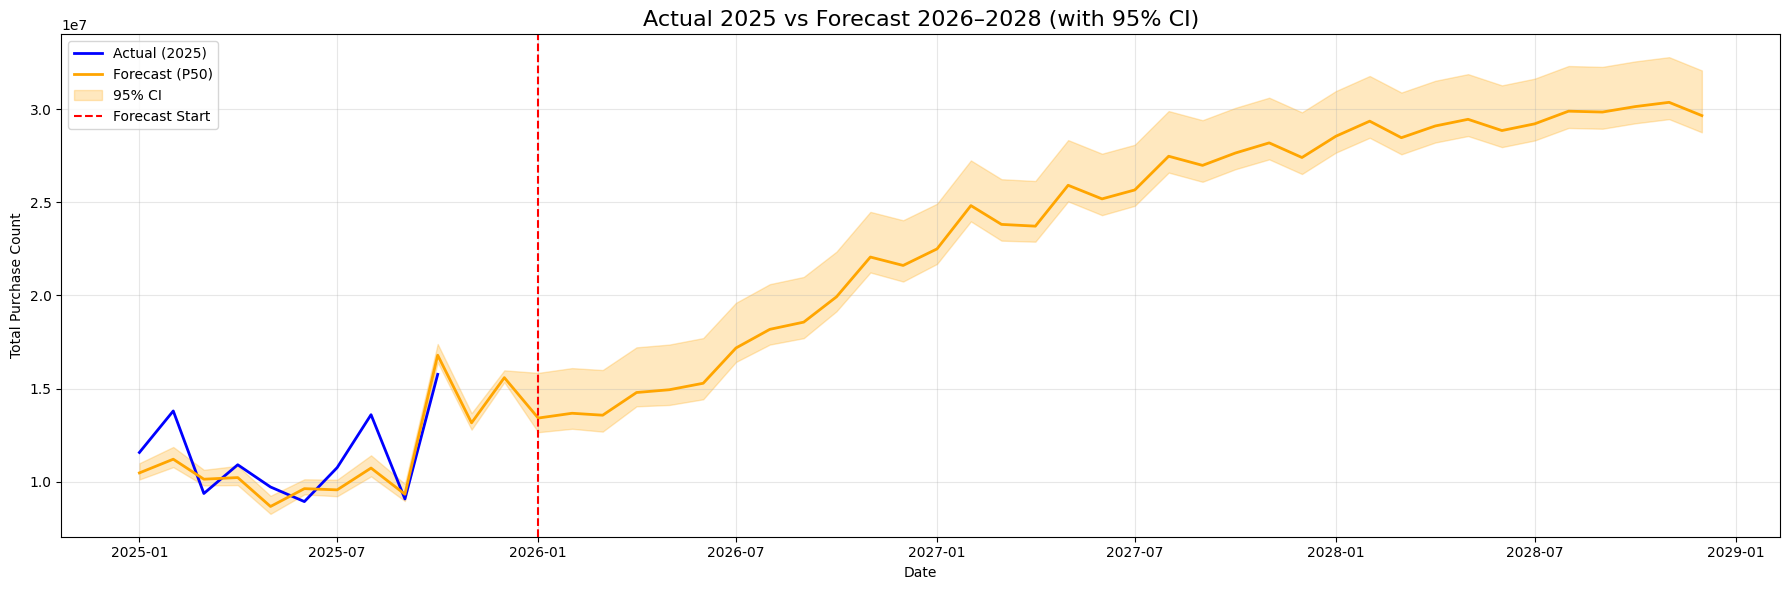

In [220]:
import matplotlib.pyplot as plt
import pandas as pd

df_plot = df_final_result.copy()
df_plot["DATE"] = pd.to_datetime(df_plot["DATE"])

# --- agg ---
df_total = (
    df_plot
    .groupby("DATE")[["FORECAST_PURCHASE", "CI_LOWER", "CI_UPPER", "ACTUAL_PURCHASE"]]
    .sum()
    .reset_index()
)

# ==== actual + forecast ====
df_actual_2025 = df_total[df_total["DATE"] < "2025-11-01"]
df_forecast_2628 = df_total[df_total["DATE"] >= "2025-01-01"]

# ======================= plot ===========================
plt.figure(figsize=(18, 6))

# --- blue line：Actual 2025 ---
plt.plot(
    df_actual_2025["DATE"],
    df_actual_2025["ACTUAL_PURCHASE"],
    color="blue",
    linewidth=2,
    label="Actual (2025)"
)

# --- orange line：Forecast 2026–2028 ---
plt.plot(
    df_forecast_2628["DATE"],
    df_forecast_2628["FORECAST_PURCHASE"],
    color="orange",
    linewidth=2,
    label="Forecast (P50)"
)

# --- CI band ---
plt.fill_between(
    df_forecast_2628["DATE"],
    df_forecast_2628["CI_LOWER"],
    df_forecast_2628["CI_UPPER"],
    color="orange",
    alpha=0.25,
    label="95% CI"
)

# plot
plt.axvline(pd.to_datetime("2026-01-01"), color="red", linestyle="--", label="Forecast Start")

plt.title("Actual 2025 vs Forecast 2026–2028 (with 95% CI)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Purchase Count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [221]:
print("REGION",df_final_result["REGION"].unique())
print("COUNTRY",df_final_result["COUNTRY"].unique())
print("SALESORG",df_final_result["SALESORG"].unique())
print("SILHOUETTE",df_final_result["SILHOUETTE"].unique())
print("GENDER",df_final_result["GENDER"].unique())
print("SPORT",df_final_result["SPORT"].unique())
print("SEASON",df_final_result["SEASON"].unique())

REGION ['EMEA' 'Emerging Markets' 'Japan' 'North America' 'Unknown']
COUNTRY ['Germany' 'United Kingdom' 'Australia' 'China' 'Hong Kong' 'Mexico'
 'New Zealand' 'South Korea' 'USA' 'Japan' 'Canada' 'Unknown']
SALESORG ['German' 'EMEA' 'Australia' 'China' 'Southeast Asia' 'Mexico'
 'New Zealand' 'South Korea' 'Latin America' 'Japan' 'Canada'
 '5th & Ocean' 'United States' 'Unknown']
SILHOUETTE ['3930' '5950' '920' '940' '950' 'Apparel' 'Others']
GENDER ['Men' 'Boys' 'Others' 'Girls' 'Women']
SPORT ['Others' 'None' 'Basketball' 'Baseball' 'Football' 'College']
SEASON ['Custom' 'Program' 'Stock' 'UNASSIGNED']


In [222]:
df_final_result.columns

Index(['REGION', 'COUNTRY', 'SALESORG', 'SILHOUETTE', 'GENDER', 'SPORT',
       'SEASON', 'YEAR', 'MONTH', 'DATE', 'FORECAST_PURCHASE',
       'ACTUAL_PURCHASE', 'CI_LOWER', 'CI_UPPER'],
      dtype='object')

In [223]:
df_final_result["FORECAST_PURCHASE"].sum()

1001011225.900578